In [ ]:
#sandbox = 'fper'
#PATH_DATA = '/data/sandboxes/'+sandbox+'/data/data/'

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
!tar -xvf spark-3.5.1-bin-hadoop3.tgz

spark-3.5.1-bin-hadoop3/
spark-3.5.1-bin-hadoop3/sbin/
spark-3.5.1-bin-hadoop3/sbin/spark-config.sh
spark-3.5.1-bin-hadoop3/sbin/stop-slave.sh
spark-3.5.1-bin-hadoop3/sbin/stop-mesos-dispatcher.sh
spark-3.5.1-bin-hadoop3/sbin/start-workers.sh
spark-3.5.1-bin-hadoop3/sbin/start-slaves.sh
spark-3.5.1-bin-hadoop3/sbin/start-all.sh
spark-3.5.1-bin-hadoop3/sbin/stop-all.sh
spark-3.5.1-bin-hadoop3/sbin/workers.sh
spark-3.5.1-bin-hadoop3/sbin/start-mesos-dispatcher.sh
spark-3.5.1-bin-hadoop3/sbin/spark-daemon.sh
spark-3.5.1-bin-hadoop3/sbin/decommission-worker.sh
spark-3.5.1-bin-hadoop3/sbin/slaves.sh
spark-3.5.1-bin-hadoop3/sbin/stop-mesos-shuffle-service.sh
spark-3.5.1-bin-hadoop3/sbin/stop-history-server.sh
spark-3.5.1-bin-hadoop3/sbin/stop-worker.sh
spark-3.5.1-bin-hadoop3/sbin/decommission-slave.sh
spark-3.5.1-bin-hadoop3/sbin/stop-thriftserver.sh
spark-3.5.1-bin-hadoop3/sbin/start-worker.sh
spark-3.5.1-bin-hadoop3/sbin/stop-slaves.sh
spark-3.5.1-bin-hadoop3/sbin/start-connect-server.sh


In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488490 sha256=04371f77f4d937293e4da752aed09a5a3779d33e39f64f7fff0cce1e2ddbf945
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [3]:
!pip install -q findspark

In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"



# Dataset

Cargamos un dataset con información de una campaña de marketing portuguesa para la venta de un préstamo bancario. El objetivo es predecir si tiene el cliente un depósito a plazo fijo con el banco



## Información sobre las variables del dataset

### Datos del cliente bancario
1. age
2. job: tipo de trabajo
3. marital: estado civil (nota: "divorced" implica tanto divorciado como viudo)
4. education
5. default: ¿no ha pagado alguna cuota de un crédito?
6. balance: saldo medio anual, en euros
7. housing: ¿tiene una hipoteca?
8. loan: ¿tiene un crédito?

### Relacionado con el último contacto con el cliente en la campaña actual
9. contact: tipo de comunicación del último contacto
10. day: día de la fecha de último contacto
11. month: mes de la fecha de último contacto
12. duration: duración del último contacto, en segundos

### Otros atributos:
13. campaign: número de contactos llevados a cabo durante esta campaña y para este cliente (incluye el último contacto)
14. pdays: número de dias que han pasado desde que el cliente fue contactado por última vez durante la pasada campaña (-1 significa que el cliente no fue contactado)
15. previous: número de contactos que se han llevado a cabo antes de esta campaña y para este cliente
16. poutcome: resultado de la última campaña de marketing

### Variable de salida (target):
17. y: ¿tiene el cliente contratado un depósito a plazo fijo?

In [5]:
import findspark
findspark.init()

findspark.find()

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

# Librerías:

In [6]:
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, IntegerType, DoubleType, DateType
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.stat import Statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest
sns.set(color_codes=True)

from pyspark.sql.types import StringType, DoubleType, IntegerType, ArrayType, DateType
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import col, when

import re
import math

In [7]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import chi2_contingency

#Lectura de datos

In [8]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
from pyspark import SQLContext
from pyspark import SparkContext
sc = SparkContext.getOrCreate()
sql = SQLContext(sc)

/content/spark-3.5.1-bin-hadoop3/python/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


#Cargar data compartida

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
bank_df = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/BBVA/bank-full.csv', sep=';', header=True, inferSchema=True)

#Secciones
* Analisis de consistencia de la data (duplicados, missing, etc).
* Analisis univariado, bivariado y multivariado.
* XGBoost


# EDA (Exploratory Data Analysis)

## Descriptive Statistical Analysis

In [12]:
bank_df.show()

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
| 58|  management| married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown| no|
| 44|  technician|  single|secondary|     no|     29|    yes|  no|unknown|  5|  may|     151|       1|   -1|       0| unknown| no|
| 33|entrepreneur| married|secondary|     no|      2|    yes| yes|unknown|  5|  may|      76|       1|   -1|       0| unknown| no|
| 47| blue-collar| married|  unknown|     no|   1506|    yes|  no|unknown|  5|  may|      92|       1|   -1|       0| unknown| no|
| 33|     unknown|  single|  unknown|     no|      1|     no|  no|unknown|  5|  may

In [ ]:
bank_df.describe().show()

+-------+------------------+-------+--------+---------+-------+------------------+-------+-----+--------+-----------------+-----+------------------+-----------------+------------------+------------------+--------+-----+
|summary|               age|    job| marital|education|default|           balance|housing| loan| contact|              day|month|          duration|         campaign|             pdays|          previous|poutcome|    y|
+-------+------------------+-------+--------+---------+-------+------------------+-------+-----+--------+-----------------+-----+------------------+-----------------+------------------+------------------+--------+-----+
|  count|             45211|  45211|   45211|    45211|  45211|             45211|  45211|45211|   45211|            45211|45211|             45211|            45211|             45211|             45211|   45211|45211|
|   mean| 40.93621021432837|   NULL|    NULL|     NULL|   NULL|1362.2720576850766|   NULL| NULL|    NULL|15.806418791886


* Algunas columnas tienen valores como "unknown" que es similar a tener un campo nulo, nos indica que por alguna razón el dato no se pudo recopilar. De entender el origen de este dato, es tentativo reemplazarlos por un valor como moda u otros. Por el momento trabajaremos con estos datos así y explicaremos como hemos procedido en las siguientes partes del informe.
*  Recordamos que en `pdays` -1 significa que el cliente no fue contactado.

In [ ]:
bank_df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



In [19]:
bank_df_pandas = bank_df.toPandas()

In [ ]:
bank_df_pandas.describe().round(1)

,age,balance,day,duration,campaign,pdays,previous
count,45211.0,45211.0,45211.0,45211.0,45211.0,45211.0,45211.0
mean,40.9,1362.3,15.8,258.2,2.8,40.2,0.6
std,10.6,3044.8,8.3,257.5,3.1,100.1,2.3
min,18.0,-8019.0,1.0,0.0,1.0,-1.0,0.0
25%,33.0,72.0,8.0,103.0,1.0,-1.0,0.0
50%,39.0,448.0,16.0,180.0,2.0,-1.0,0.0
75%,48.0,1428.0,21.0,319.0,3.0,-1.0,0.0
max,95.0,102127.0,31.0,4918.0,63.0,871.0,275.0


## Insights 1:
Se puede ver que, de las personas que se tiene información que participaron en la campaña de márketing:
* `age`: El promedio de ellas es joven, aprox. 41 años. El 75% de personas es menor de 48 años.
* `balance`: El promedio tiene un balance de cuenta medio anual de aprox. € 1362. Además, el 75% de los datos es menor a € 1428.
* `duration`: El promedio del tiempo del último contacto es de aprox. 4 minutos. El 75% de últimos contactos fue menor a 5 minutos aprox.
* `campaing`: En promedio se les ha contactado 3 veces a cada uno durante la campaña.
* `previous`: En promedio los clientes que participaron en esta campaña son nuevos prospectos (no contactados antes), valor aprox 0.

Futuro Análisis: Analizar quartiles, distribución normal, etc.

## Checking for null or duplicate values

In [ ]:
# Calculate the count of null values for each column
null_counts = bank_df_pandas.isnull().sum()
null_counts

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

No hay columnas con valores nulos en el dataset.

In [ ]:
duplicate_rows = bank_df_pandas[bank_df_pandas.duplicated()]

# Print the number of duplicate rows
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")

Number of duplicate rows: 0


No hay filas repetidas en el dataset.

In [ ]:
print(f"Number of Columns: {len(bank_df.columns)}")

Number of Columns: 17


Considerando que todavía ninguna variable categórica está codificada (convertida en números) podemos separar los features:

In [15]:
print(f"Columns: {bank_df.columns}")

# Show data types of each column
print("Data Types:")
numerical_cols = []
categorical_cols = []
for column, dtype in bank_df.dtypes:
    if dtype in ['int', 'bigint', 'double', 'float']:
      numerical_cols.append(column)
    else:
      categorical_cols.append(column)
    print(f"{column}: {dtype}")

Columns: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
Data Types:
age: int
job: string
marital: string
education: string
default: string
balance: int
housing: string
loan: string
contact: string
day: int
month: string
duration: int
campaign: int
pdays: int
previous: int
poutcome: string
y: string


In [ ]:
numerical_cols

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [ ]:
print(f"Del todal de 17 columnas, {len(numerical_cols)} son numéricas.")

Del todal de 17 columnas, 7 son numéricas.


In [ ]:
categorical_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'y']

In [ ]:
print(f"Del todal de 17 columnas, {len(categorical_cols)} son categóricas.")

Del todal de 17 columnas, 10 son categóricas.


In [ ]:
bank_df.select("job").distinct().show()

+-------------+
|          job|
+-------------+
|   management|
|      retired|
|      unknown|
|self-employed|
|      student|
|  blue-collar|
| entrepreneur|
|       admin.|
|   technician|
|     services|
|    housemaid|
|   unemployed|
+-------------+



In [ ]:
bank_df.select("job").distinct().count()

12

In [ ]:
# Show distinct values in a categorical column (e.g., job)
for column in bank_df.columns:
  bank_df.select(column).distinct().show()

+---+
|age|
+---+
| 31|
| 85|
| 65|
| 53|
| 78|
| 34|
| 81|
| 28|
| 76|
| 27|
| 26|
| 44|
| 22|
| 47|
| 52|
| 86|
| 40|
| 20|
| 94|
| 57|
+---+
only showing top 20 rows

+-------------+
|          job|
+-------------+
|   management|
|      retired|
|      unknown|
|self-employed|
|      student|
|  blue-collar|
| entrepreneur|
|       admin.|
|   technician|
|     services|
|    housemaid|
|   unemployed|
+-------------+

+--------+
| marital|
+--------+
|divorced|
| married|
|  single|
+--------+

+---------+
|education|
+---------+
|  unknown|
| tertiary|
|secondary|
|  primary|
+---------+

+-------+
|default|
+-------+
|     no|
|    yes|
+-------+

+-------+
|balance|
+-------+
|    148|
|    471|
|   -125|
|   2142|
|    496|
|   1342|
|    463|
|   3749|
|   1088|
|  11317|
|   1238|
|   3175|
|   3997|
|   -362|
|   2366|
|   4519|
|   1959|
|   7982|
|   -565|
|   6397|
+-------+
only showing top 20 rows

+-------+
|housing|
+-------+
|     no|
|    yes|
+-------+

+----+
|lo

## Histograms for numerical columns

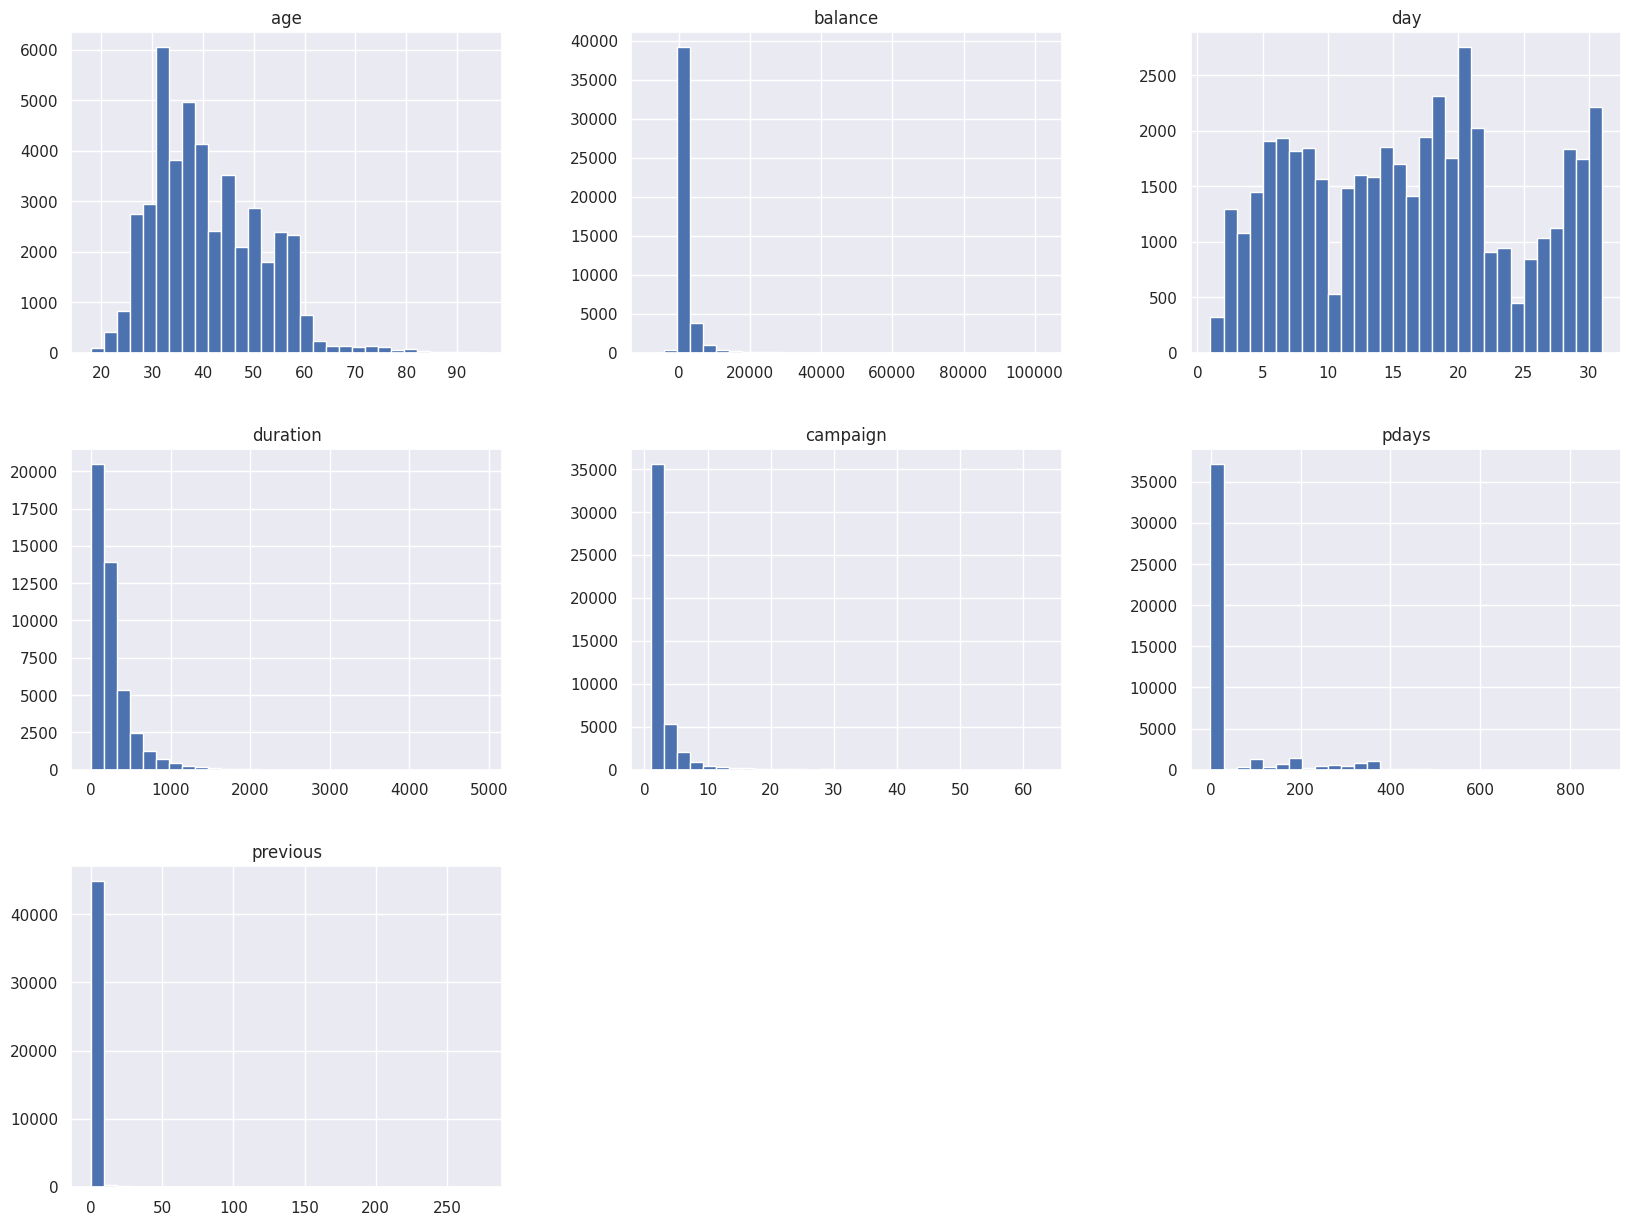

In [ ]:
bank_df_pandas.hist(bins=30, figsize=(20, 15))
plt.show()

Los resultados de los histogramas nos permiten ver de forma gráfica lo que mecionamos en el apartado de **Insights 1** resultado de las estadísticas descriptivas, complementando esa información:
* `age`: Se puede ver que la mayoría de personas encuestadas es relativamente joven.
* `day`: se puede ver que los días en que se contactan a las personas tiene una estacionalidad semanal, probablemente se contacta una mayor cantidad de clientes al inicio de semana o tal vez al final de cada semana.


##Histograms for categorical columns

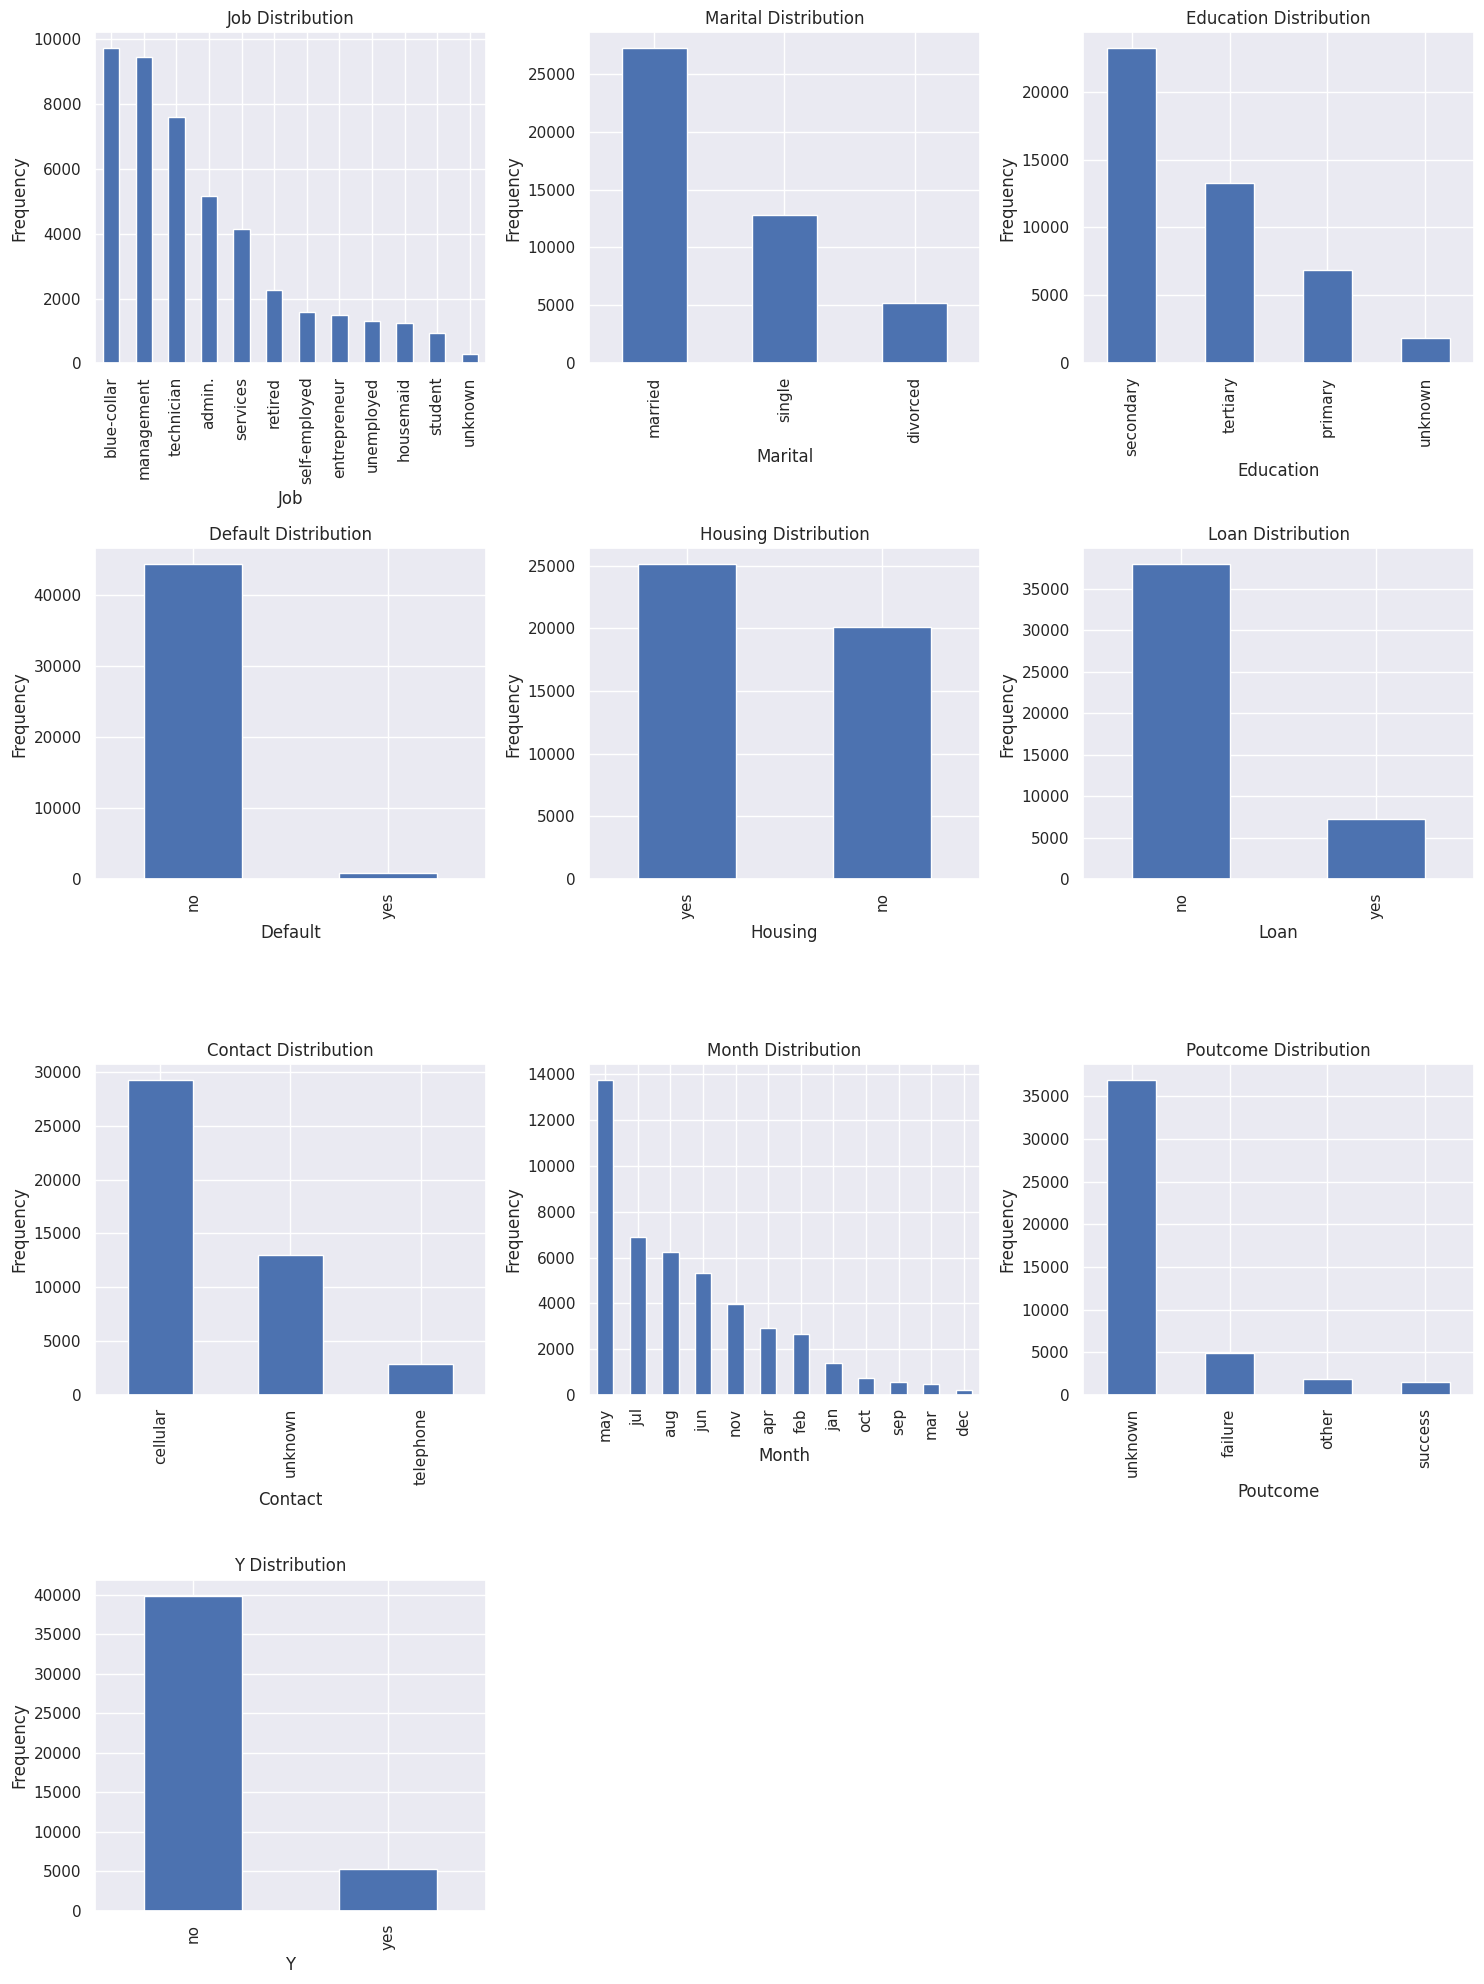

In [29]:
def hist_categorical_columns(df, columns):
  num_cols = 3
  num_rows = math.ceil(len(columns) / num_cols)
  fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5)) # Create subplots
  axes = axes.flatten()
  for i, col in enumerate(columns):
      df[col].value_counts().plot(kind='bar', ax=axes[i], title=f'{col.capitalize()} Distribution')
      axes[i].set_xlabel(col.capitalize())
      axes[i].set_ylabel('Frequency')

  # Remove any empty subplots
  for j in range(i + 1, len(axes)):
      fig.delaxes(axes[j])
  # Adjust layout
  plt.tight_layout()
  plt.show()

hist_categorical_columns(bank_df_pandas, categorical_cols)

## Insights 2:
Podemos entender lo siguiente de los histogramas:
* Casi todas de las variables categóricas tienen una moda bastante marcada. Dependiendo de la variable se pueden entender cómo se ha venido trabajando la campaña (qué tipo de contacto fue el más utilizado, qué mes fue el de contacto, entre otros.)
* Se evidencia que el **target variable 'y' presentan problema de data desbalanceada**, es decir, la diferencia entre las clases sobrerepresentadas y las subrepresentadas es significante. Por ello se aplicará métodos de Oversamplig y Undersampling antes de entrenar el modelo. Esto con el objetivo de que el algoritmo aprenda adecuadamente a generalizar todas las clases presentes en la data, en este caso solo 'yes' y 'no'.


## Pie Charts

Se procederá a crear Pie charts de los features categóricos para ver cuánto % representan sus respectivas clases.

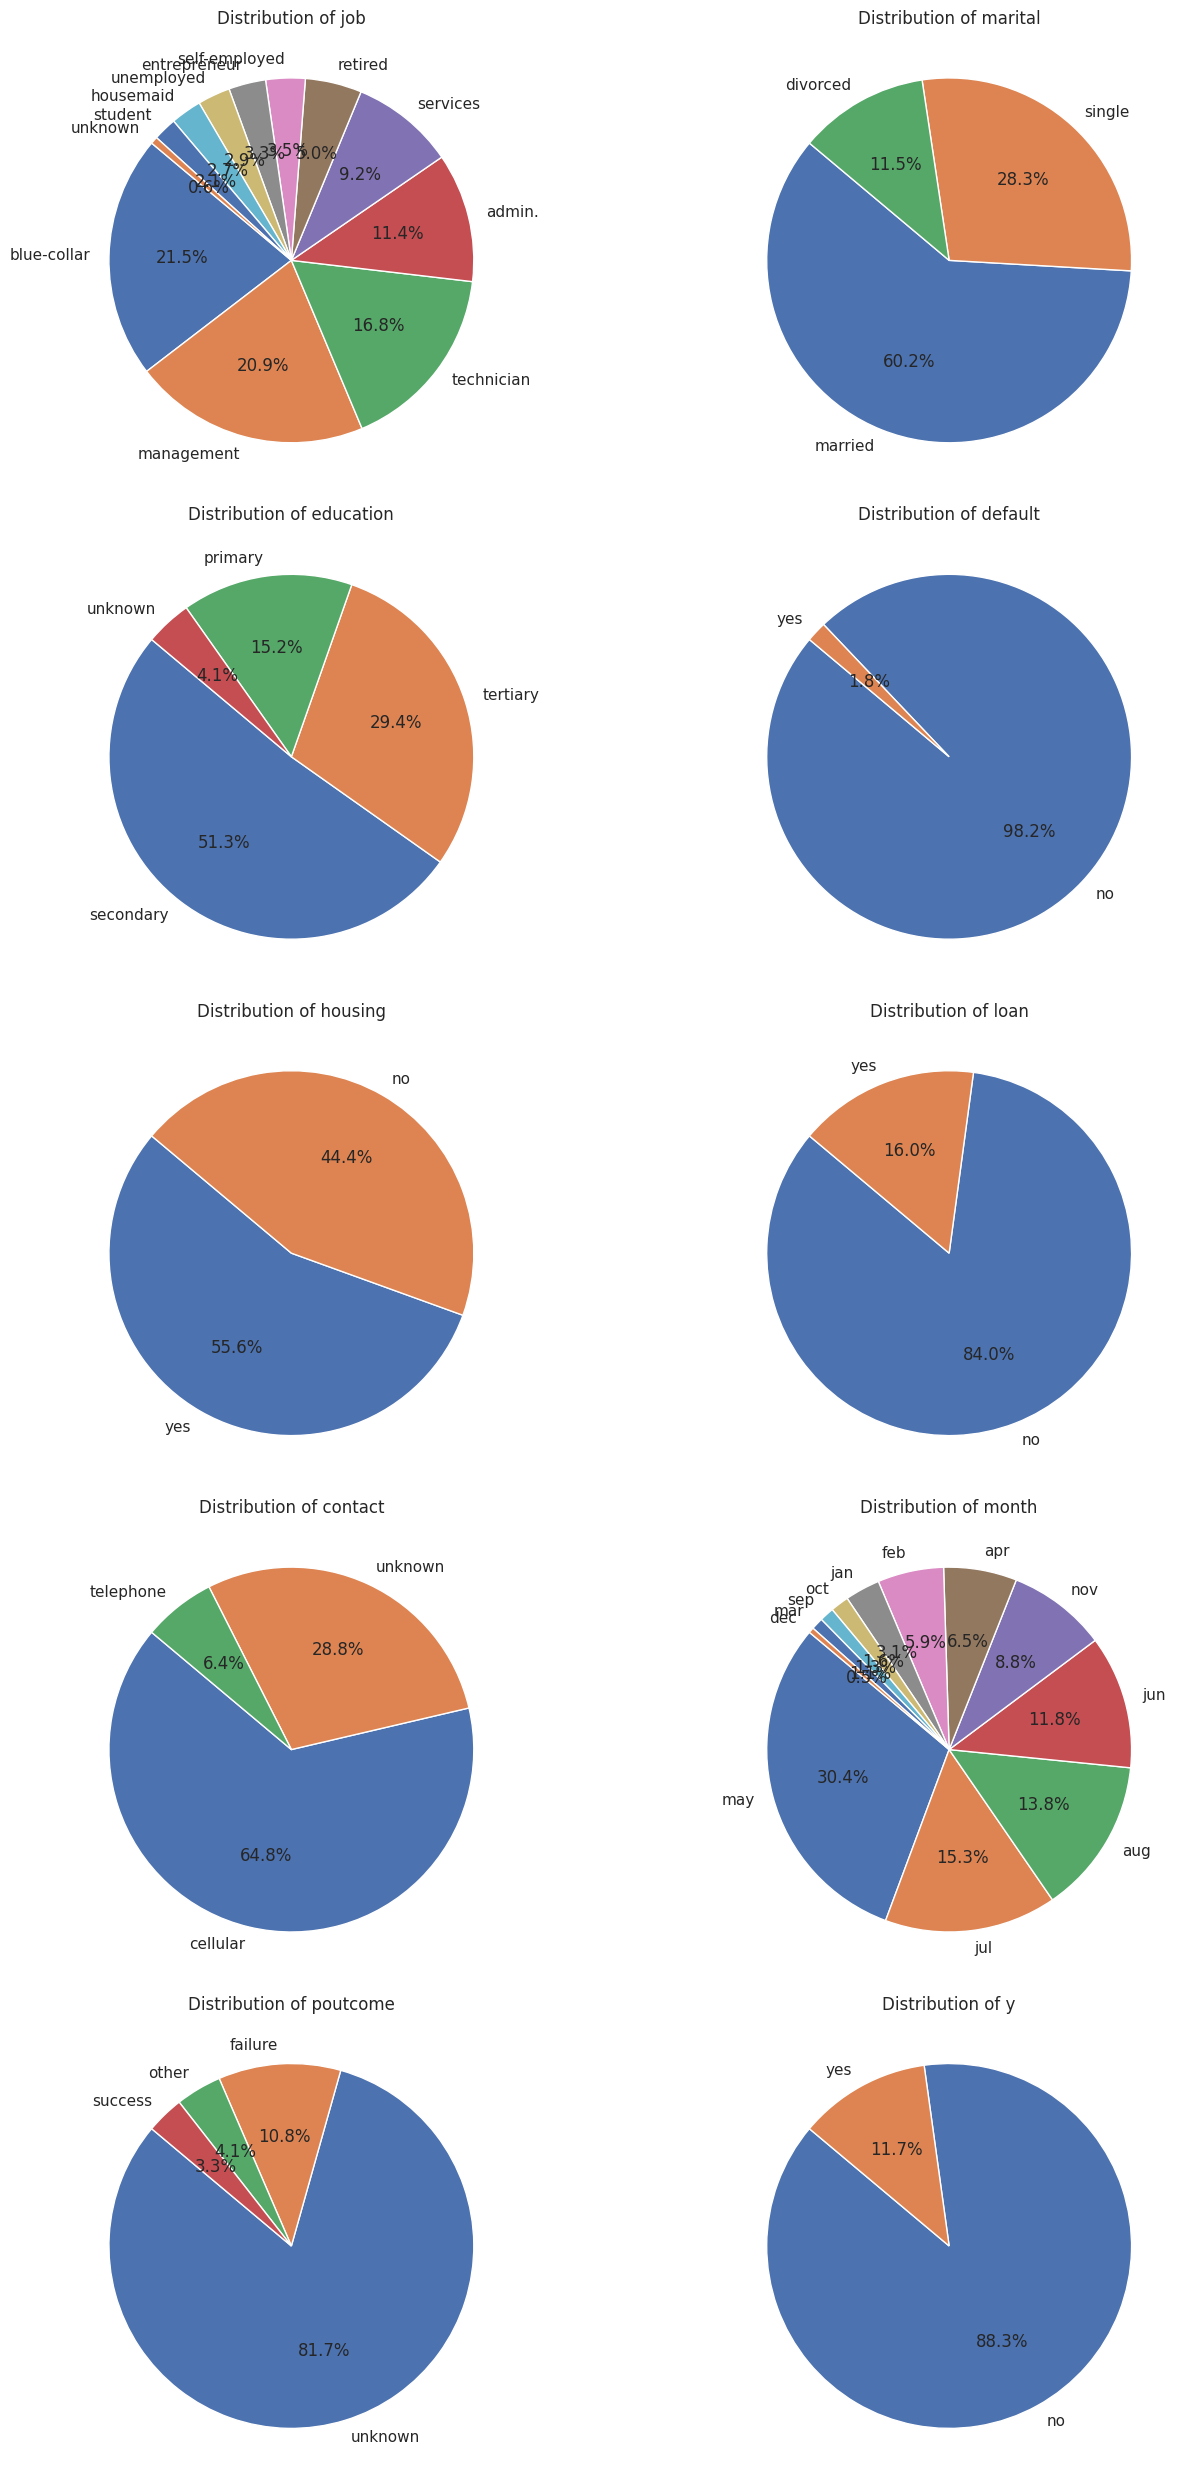

In [ ]:
# Number of categorical columns
num_categorical_cols = len(categorical_cols)

# Calculate the number of rows needed for the grid (2 columns)
num_rows = (num_categorical_cols + 1) // 2

# Create a figure with subplots grid
fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5 * num_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each categorical column in a separate subplot
for i, col in enumerate(categorical_cols):
    # Calculate the value counts for the current column
    value_counts = bank_df_pandas[col].value_counts(normalize=True)

    # Plot the pie chart
    axes[i].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)

    # Set the title for the subplot
    axes[i].set_title(f'Distribution of {col}')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


Como se puede ver, en mucha en la variable target 'y' la data es muy desbalanceada. Por ello se aplicará métodos de oversamplig y undersampling.

## Bi-variate Analysis

Se procederá a hacer un análisis de las relaciones entre dos variables que podrían tener interdependecia, similitudes, etc.

Principalmente se emplearán Tablas de Contigencia y el Test de Independecia Chi-Square asumiendo un grado de error del 5%.

Null hypothesis = Las variables son independientes.

Si p-value < 0.05, hay fuerte evidencia en contra de Null hypothesis.

### housing vs loan
Lo primero que se me viene a la cabeza es saber si las variables `housing` y `loan` tienen una estrecha relación o no. Ya que, si la persona tiene una hipoteca, es probable que tenga también un crédito/préstamo.Si es así, se podría eliminar una de ellas. Lo verificatemos con una tabla de contigencia.


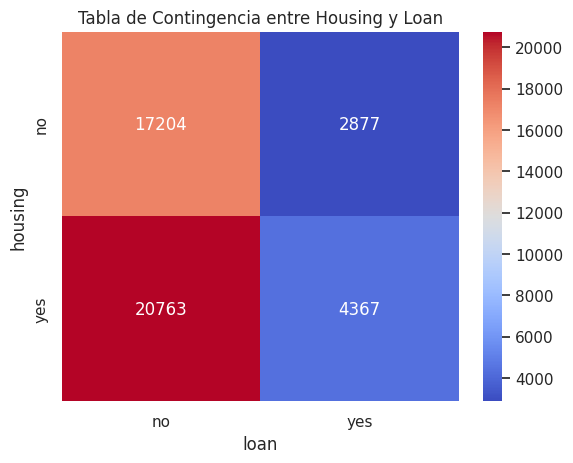

In [ ]:
contingency_table = pd.crosstab(bank_df_pandas['housing'], bank_df_pandas['loan'])
sns.heatmap(contingency_table, annot=True, cmap='coolwarm', fmt='d')
plt.title('Tabla de Contingencia entre Housing y Loan')
plt.show()


In [ ]:
contingency_table.sum()

loan
no     37967
yes     7244
dtype: int64

In [ ]:
# La suma por columna será 100%
contingency_table_per = pd.crosstab(bank_df_pandas['housing'], bank_df_pandas['loan'], normalize='columns').round(3)
contingency_table_per

loan,no,yes
housing,,
no,0.453,0.397
yes,0.547,0.603


In [ ]:
# La suma de todas las frecuencias será 100%
contingency_table_per = pd.crosstab(bank_df_pandas['housing'], bank_df_pandas['loan'], normalize=True).round(3)
contingency_table_per

loan,no,yes
housing,,
no,0.381,0.064
yes,0.459,0.097


In [ ]:
print(f"El total de personas es {20763+17204+2877+4367}")

El total de personas es 45211


In [ ]:
# Realizando el test Chi-Square y evaluar independencia entre variables
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2:.2f}")
print(f"P-Value: {p}")

if p < 0.05:
    print("Sí hay una asocicación significativa entre housing y loan.")
else:
    print("No hay una asocicación significativa entre housing y loan.")


Chi-Square Statistic: 76.97
P-Value: 1.7315256945310098e-18
Sí hay una asocicación significativa entre housing y loan.


In [ ]:
expected

array([[16863.49178297,  3217.50821703],
       [21103.50821703,  4026.49178297]])

## Insights 3:
* Podemos ver que casi el ≈54.7% de personas que no tienen crédito o `loan`tiene una hipoteca o `housing`. Pero este hallazgo tiene sentido ya que sería de repente ya sería mucho endeudamiento contar con ambos tipos de préstamos.

* Vemos también qué el **≈38.1% del total de personas (45 211 personas) no tienen ni hipoteca ni préstamo, con lo cual me lleva a pensar que, al no tener necesidad de  prestar dinero, se encuentran estables financieramente y lo podrían tener en un depósito de plazo fijo** (variable target).

* Se puede ver también que del total de personas solo 4 367 ≈10% adquirieron un préstamo y una hipoteca.

### housing vs 'y' (target)

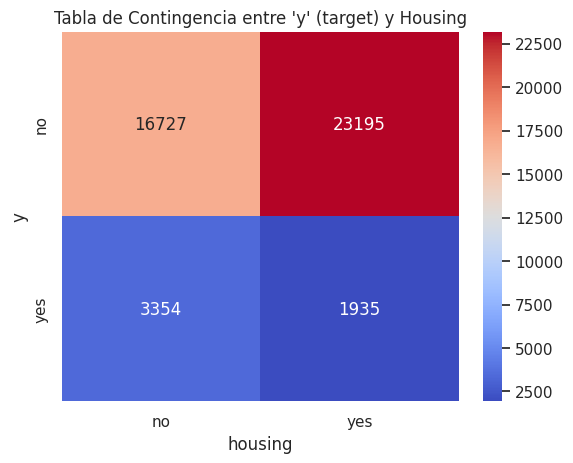

In [ ]:
contingency_table = pd.crosstab(bank_df_pandas['y'], bank_df_pandas['housing'])
sns.heatmap(contingency_table, annot=True, cmap='coolwarm', fmt='d')
plt.title("Tabla de Contingencia entre 'y' (target) y Housing")
plt.show()

In [ ]:
contingency_table.sum()

housing
no     20081
yes    25130
dtype: int64

In [ ]:
# Suma de las columnas es 100%
contingency_table_per = pd.crosstab(bank_df_pandas['y'], bank_df_pandas['housing'], normalize="columns").round(3)
contingency_table_per

housing,no,yes
y,,
no,0.833,0.923
yes,0.167,0.077


In [ ]:
# Suma de todas las frecuencias es 100%
contingency_table_per = pd.crosstab(bank_df_pandas['y'], bank_df_pandas['housing'], normalize=True).round(3)
contingency_table_per

housing,no,yes
y,,
no,0.370,0.513
yes,0.074,0.043


In [ ]:
# Realizando el test Chi-Square y evaluar independencia entre variables
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2:.2f}")
print(f"P-Value: {p}")

if p < 0.05:
    print("Sí hay una asocicación significativa entre housing y 'y' (target).")
else:
    print("No hay una asocicación significativa entre housing y 'y' (target).")

Chi-Square Statistic: 874.82
P-Value: 2.918797605076633e-192
Sí hay una asocicación significativa entre housing y 'y' (target).


## Insights 4:
* Se ve que el **92.3% de personas que cuentan con una hipoteca o `housing`, no tienen un depósito de plazo fijo o `y`**. Esto debido a que probablemente, después de pagar el mes ya no tienen dinero suficiente para ahorrarlo y depositarlo. **Esto nos podría llevar a enfocar la campaña de marketing en personas sin hipotecas.**

* Solo el 16.7% de personas que **no** cuentan con una hipoteca o `housing` sí tienen un depósito de plazo fijo o `y`. **Este dato sin embargo, nos hace entender que si bien el 92.3% de personas que sí tiene hipotecas ya no tiene un depósito de plazo fijo, asumir lo inverso no es correcto. Pues No tener hipoteca tampoco implica que la persona tenga un depósito plazo fijo (solo 16.7% de personas).**

### loan vs 'y' (target)

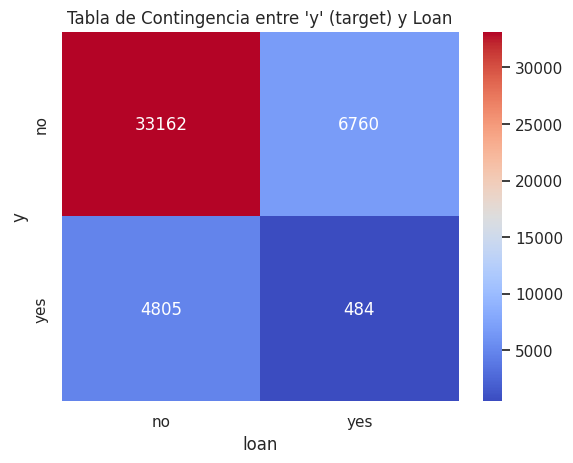

In [ ]:
contingency_table = pd.crosstab(bank_df_pandas['y'], bank_df_pandas['loan'])
sns.heatmap(contingency_table, annot=True, cmap='coolwarm', fmt='d')
plt.title("Tabla de Contingencia entre 'y' (target) y Loan")
plt.show()

In [ ]:
contingency_table.sum()

loan
no     37967
yes     7244
dtype: int64

In [ ]:
# Suma por columna es 100%
contingency_table_per = pd.crosstab(bank_df_pandas['y'], bank_df_pandas['loan'], normalize="columns").round(3)
contingency_table_per

loan,no,yes
y,,
no,0.873,0.933
yes,0.127,0.067


In [ ]:
# Suma de todas las frecuencias es 100%
contingency_table_per = pd.crosstab(bank_df_pandas['y'], bank_df_pandas['loan'], normalize=True).round(3)
contingency_table_per

loan,no,yes
y,,
no,0.733,0.150
yes,0.106,0.011


In [ ]:
# Realizando el test Chi-Square y evaluar independencia entre variables
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2:.2f}")
print(f"P-Value: {p}")

if p < 0.05:
    print("Sí hay una asocicación significativa entre 'y' (target) y loan.")
else:
    print("No hay una asocicación significativa entre 'y' (target) y loan.")

Chi-Square Statistic: 209.62
P-Value: 1.665061163492756e-47
Sí hay una asocicación significativa entre 'y' (target) y loan.


## Insights 5:
* Podemos ver que el **87.3% de personas sin préstamo o `loan` no tienen un depósito de plazo fijo**, contrario a lo que la intuición podría decirte, es por ello que las hipótesis deben siempre validarse con data real.

* Solo el 12.7% de personas sin préstamo o `loan` **sí** tienen un depósito de plazo fijo. Con lo cual no sería muy fructífero enfocar la campaña de marketing en personas sin préstamos.

* Solo el 1% del total de personas (45 211) sí tienen un préstamo y un depósito de plazo fijo. Esto tiene sentido, pues si están endeudadas, no tendrían dinero para depositarlo.

### marital vs housing

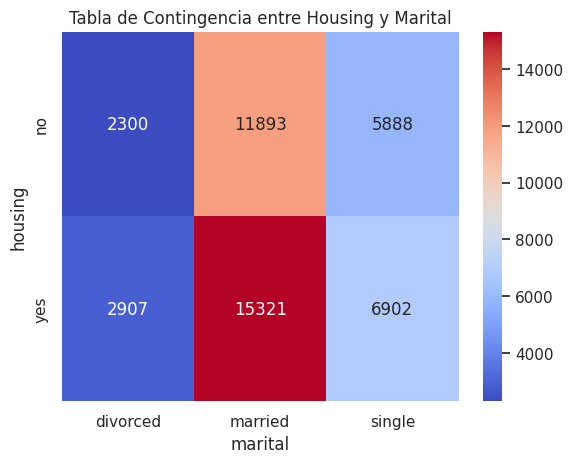

In [ ]:
contingency_table = pd.crosstab(bank_df_pandas['housing'], bank_df_pandas['marital'])
sns.heatmap(contingency_table, annot=True, cmap='coolwarm', fmt='d')
plt.title("Tabla de Contingencia entre Housing y Marital")
plt.show()

In [ ]:
contingency_table.sum()

marital
divorced     5207
married     27214
single      12790
dtype: int64

In [ ]:
# Suma por columna 100%
contingency_table_per = pd.crosstab(bank_df_pandas['housing'], bank_df_pandas['marital'], normalize="columns").round(3)
contingency_table_per

marital,divorced,married,single
housing,,,
no,0.442,0.437,0.46
yes,0.558,0.563,0.54


In [ ]:
# Suma de frecuencias 100%
contingency_table_per = pd.crosstab(bank_df_pandas['housing'], bank_df_pandas['marital'], normalize=True).round(3)
contingency_table_per

marital,divorced,married,single
housing,,,
no,0.051,0.263,0.130
yes,0.064,0.339,0.153


In [ ]:
# Realizando el test Chi-Square y evaluar independencia entre variables
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2:.2f}")
print(f"P-Value: {p}")

if p < 0.05:
    print("Sí hay una asocicación significativa entre housing y marital.")
else:
    print("No hay una asocicación significativa entre housing y marital.")

Chi-Square Statistic: 19.34
P-Value: 6.29978462961484e-05
Sí hay una asocicación significativa entre housing y marital.


 ## Insights 6:
 * Se puede ver que el **56.3% de personas casadas sí tienen un hipoteca. Debemos recordar de un análsis anterior que, el 92.3% de personas con hipoteca, no tienen un depósito de plazo fijo. Con lo cual hay una probabilidad máxima (ideal) que el 52% de personas casadas no tenga un depósito de plazo fijo (otros factores pueden hacer que este % sea menor).**
 * Cabe recalcar que el 54% de personas a pesar de estar solteras tiene una hipoteca.


### marital vs 'y' (target)

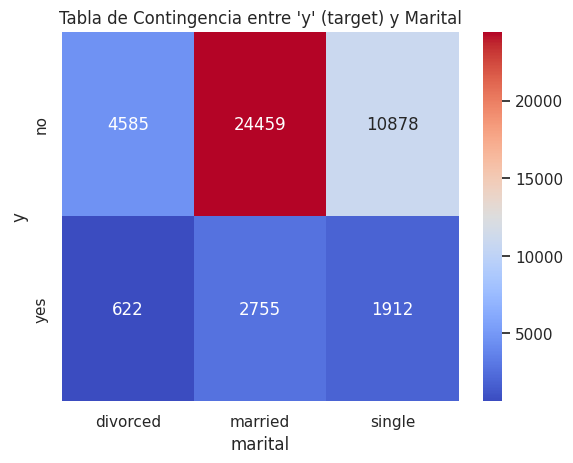

In [ ]:
contingency_table = pd.crosstab(bank_df_pandas['y'], bank_df_pandas['marital'])
sns.heatmap(contingency_table, annot=True, cmap='coolwarm', fmt='d')
plt.title("Tabla de Contingencia entre 'y' (target) y Marital")
plt.show()

In [ ]:
contingency_table.sum()

marital
divorced     5207
married     27214
single      12790
dtype: int64

In [ ]:
# Suma por columna es 100%
contingency_table_per = pd.crosstab(bank_df_pandas['y'], bank_df_pandas['marital'], normalize="columns").round(3)
contingency_table_per

marital,divorced,married,single
y,,,
no,0.881,0.899,0.851
yes,0.119,0.101,0.149


In [ ]:
# Suma de todas las frecuencias es 100%
contingency_table_per = pd.crosstab(bank_df_pandas['y'], bank_df_pandas['marital'], normalize=True).round(3)
contingency_table_per

marital,divorced,married,single
y,,,
no,0.101,0.541,0.241
yes,0.014,0.061,0.042


In [ ]:
# Realizando el test Chi-Square y evaluar independencia entre variables
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2:.2f}")
print(f"P-Value: {p}")

if p < 0.05:
    print("Sí hay una asocicación significativa entre marital y 'y' (target).")
else:
    print("No hay una asocicación significativa entre housing y 'y' (target).")

Chi-Square Statistic: 196.50
P-Value: 2.1450999986791486e-43
Sí hay una asocicación significativa entre marital y 'y' (target).


## Insights 7:
* Se validó que **el 89.9% de personas casadas no cuentan con un depósito de plazo fijo.** Lo que llevaría a pesar a que si la persona no es casada (divorciada o soltera) sí podría tener un depósito de plazo fijo.
* Sin embargo, **solo el 5.6% del total personas, no son casadas (divorciada o soltera) y sí tiene un depósito de plazo fijo. Esto nos permite entender que la relación inversa a la pensada en el punto anterior no es correcta y no maldireccionar la campaña de marketing.**

### education vs 'y' (target)

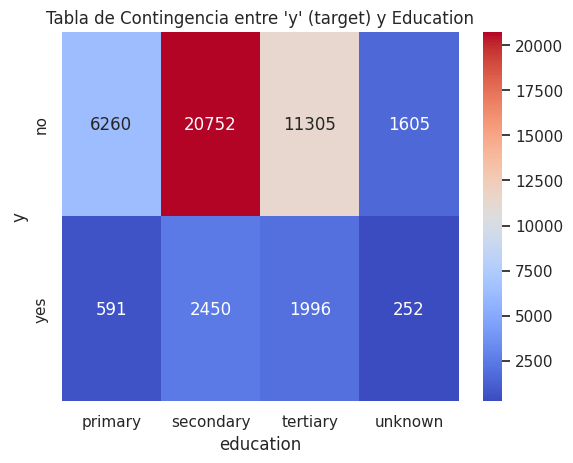

In [ ]:
contingency_table = pd.crosstab(bank_df_pandas['y'], bank_df_pandas['education'])
sns.heatmap(contingency_table, annot=True, cmap='coolwarm', fmt='d')
plt.title("Tabla de Contingencia entre 'y' (target) y Education")
plt.show()

In [ ]:
contingency_table.sum()

education
primary       6851
secondary    23202
tertiary     13301
unknown       1857
dtype: int64

In [ ]:
# Suma por columna es 100%
contingency_table_per = pd.crosstab(bank_df_pandas['y'], bank_df_pandas['education'], normalize="columns").round(3)
contingency_table_per

education,primary,secondary,tertiary,unknown
y,,,,
no,0.914,0.894,0.85,0.864
yes,0.086,0.106,0.15,0.136


In [ ]:
# Suma de total las frecuencias es 100%
contingency_table_per = pd.crosstab(bank_df_pandas['y'], bank_df_pandas['education'], normalize=True).round(3)
contingency_table_per

education,primary,secondary,tertiary,unknown
y,,,,
no,0.138,0.459,0.250,0.036
yes,0.013,0.054,0.044,0.006


In [ ]:
# Realizando el test Chi-Square y evaluar independencia entre variables
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2:.2f}")
print(f"P-Value: {p}")

if p < 0.05:
    print("Sí hay una asocicación significativa entre education y 'y' (target).")
else:
    print("No hay una asocicación significativa entre education y 'y' (target).")

Chi-Square Statistic: 238.92
P-Value: 1.6266562124072994e-51
Sí hay una asocicación significativa entre education y 'y' (target).


## Insights 8:
* Hay que tomar en cuenta que el conjunto de personas con solo primaria es pequeño solo un total de un 15% de data. 51% de personas con educación secundaria y 30% terciaria.

* El 91.4% de personas con secundaria y el 89.4% de personas con estudios terciarios, no tienen un depósito de plazo fijo. Con lo cual se asegura que por tener eduación no necesariamente se tendrá un depósito de plazo fijo. Incluso se puede pensar que tienen una asociación inversa. Pero hay que entender que son varios factores los que llevar a tener un depósito de plazo fijo, no solo educación.

## Multi-variate Analysis

In [ ]:
education_counts = bank_df_pandas.groupby(['job','education', 'y']).size().reset_index(name='counts')
education_counts

,job,education,y,counts
0,admin.,primary,no,197
1,admin.,primary,yes,12
2,admin.,secondary,no,3717
3,admin.,secondary,yes,502
4,admin.,tertiary,no,473
...,...,...,...,...
91,unknown,secondary,yes,9
92,unknown,tertiary,no,35
93,unknown,tertiary,yes,4
94,unknown,unknown,no,109


In [ ]:
jobs_list = list(bank_df_pandas["job"].unique())
jobs_list

['management',
 'technician',
 'entrepreneur',
 'blue-collar',
 'unknown',
 'retired',
 'admin.',
 'services',
 'self-employed',
 'unemployed',
 'housemaid',
 'student']

In [ ]:
fig = px.bar(education_counts, x='education', y='counts', color='job',barmode='group',
              title=f'Distribution of Education Levels for Job',
              labels={'counts': 'Frequency', 'education': 'Education Level'})
fig.show()

Obtuve el gráfico de arriba experimentando, si bien no es muy intuitio y podría mejorarse. La primera mitad de cada barra son los "no" tienen un depósito de plazo fijo y las segunda parte son los "si" tienen un depósito de plazo fijo, es un stack bar chart, agrupado por Education Level para cada clase del tipo Job.

A continuación el gráfico de arriba separado por cada trabajo:

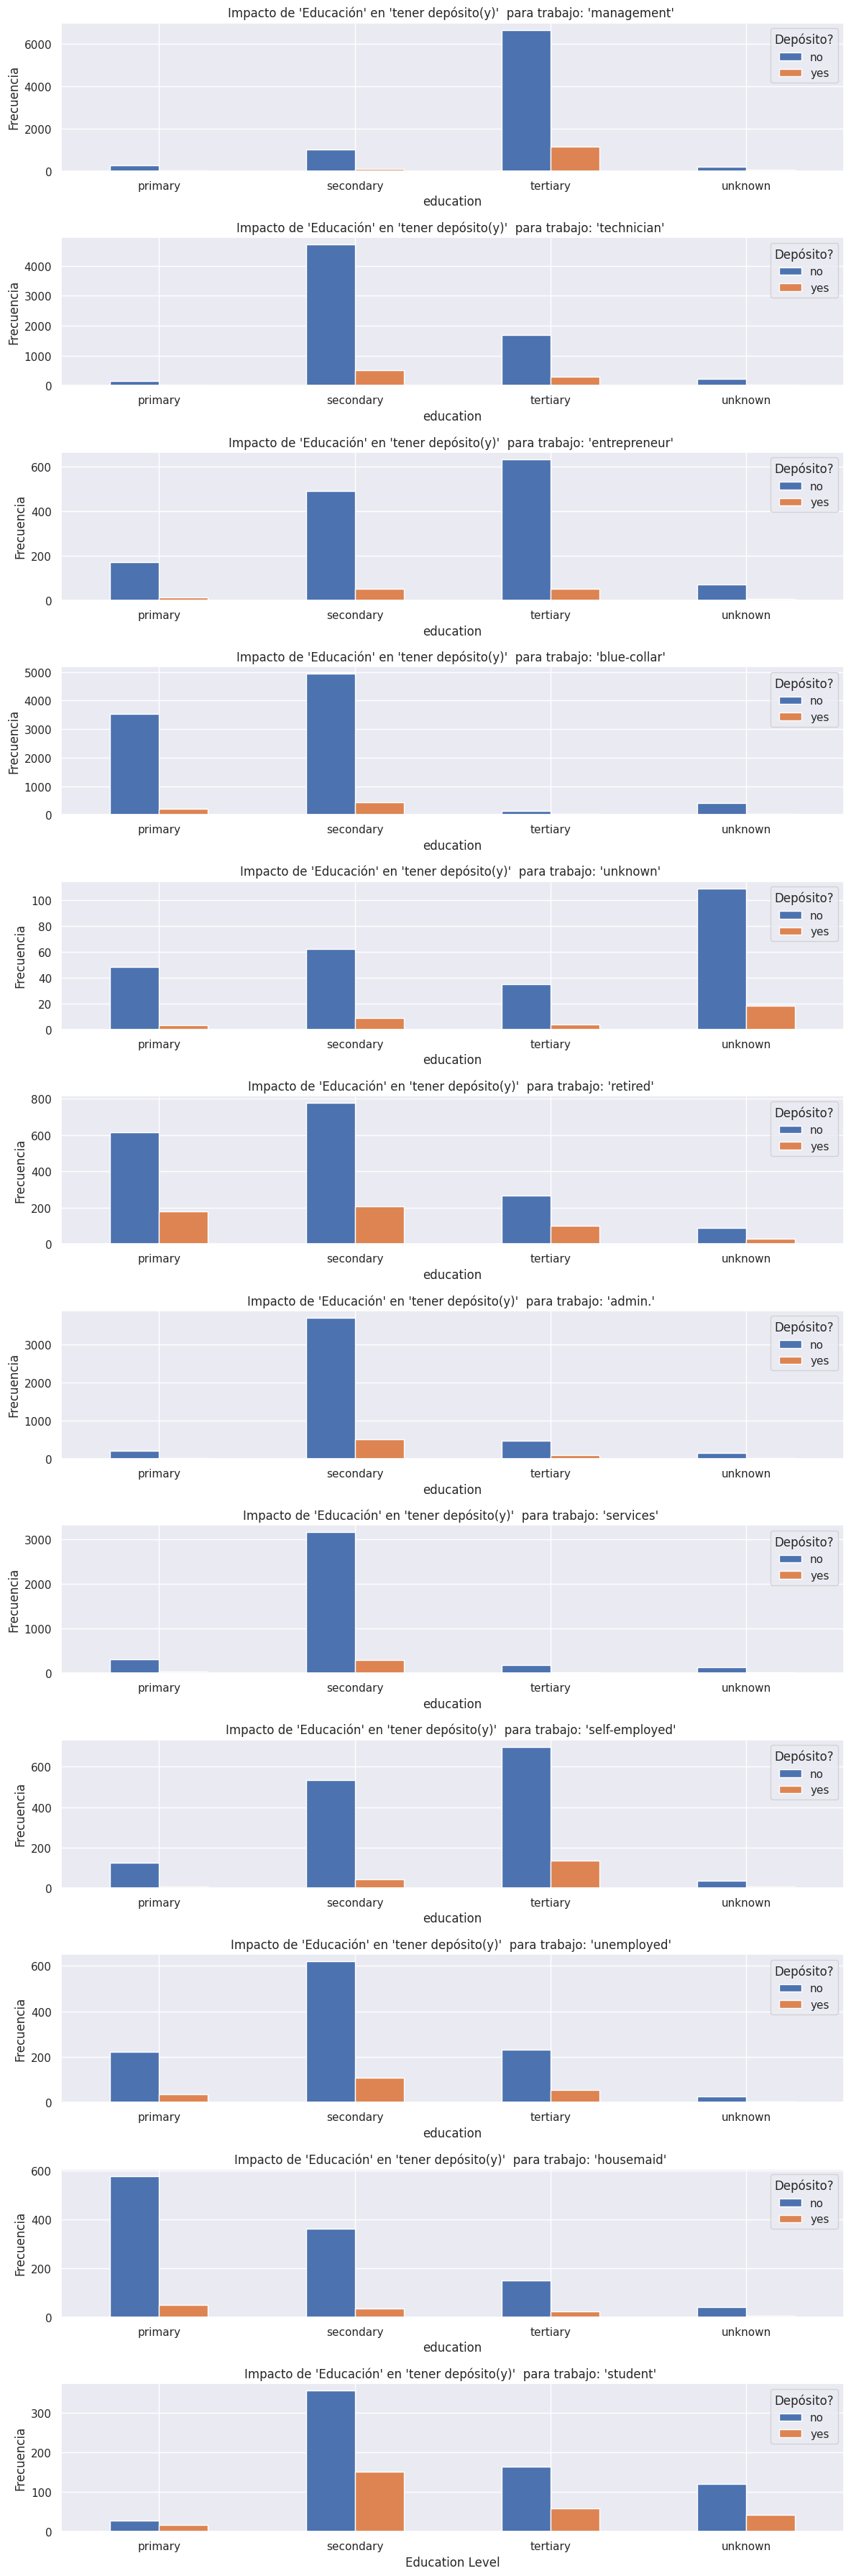

In [ ]:
num_rows = len(jobs_list)
fig, axes = plt.subplots(num_rows, 1, figsize=(12, num_rows * 3)) # Create subplots

axes = axes.flatten()
for i, col in enumerate(jobs_list):
     # Filter the DataFrame for the current job
    job_df = education_counts[education_counts['job'] == col]

    # Pivot the DataFrame for better plotting
    pivot_df = job_df.pivot(index='education', columns='y', values='counts').fillna(0)

    # Plot the bar chart
    pivot_df.plot(kind='bar', stacked=False, ax=axes[i])

    # Set the title for the subplot
    axes[i].set_title(f"Impacto de 'Educación' en 'tener depósito(y)'  para trabajo: '{col}' ")
    axes[i].set_ylabel('Frecuencia')

    axes[i].set_xticklabels(pivot_df.index, rotation=0)

    # Change the legend title
    legend = axes[i].get_legend()
    legend.set_title('Depósito?')

# Set a common x-axis label
axes[-1].set_xlabel('Education Level')

# Adjust layout
plt.tight_layout()
plt.show()

# Handling Imbalanced Data

Como se pueden ver en el histogramas, pie charts, en los análisis realizados, la data del target variable 'y' se encuentra desbalanceada. Es por ello que se procederá a realizar los siguentes procesamientos de data:

* **Oversamplig:** Para mejorar la representación de las clases subrepresentadas. En este caso se eligirá la variante SMOTENC del algoritmo SMOTE (Synthetic Minority Oversampling Technique) ya que permite trabajar con data mixta (con features continuos y categóricos).

  * Recordemos que SMOTE genera data sintética de la minoría interpolando los datos existentes, es decir, generando datos similares a los ya existentes. A diferencia de ADASYN que genera data sintética similar a los datos más dificiles de aprender (cerca de las fronteras si lo vemos desde un punto de vista de KNN).
  * Se podría experimentar utilanzo ADASYN o algún otro algoritmo de Oversampling.

* **Undersamplig:** Reducir un poco las clases sobrerepresentadas. Es tentativo emplear el algoritmo TOME LINK; sin embargo, este algoritmo funciona solo para variables continuas, con lo cual habría primero que aplicar preprocesamiento a los features categóricos para facilitar el cálculo de las distancias, además de entender un poco mejor su funcionamiento para proceder.
  * El algoritmo encuentra TOME LINKs para eliminar data. Es decir, busca dos datos que estén muy cercanos (similares) de diferentes clases y elimina el de la clase mayoritaria.
  * Se podría experimentar con otros algoritmos de undesampling.

La librería que contiene estos algoritmos es **imbalanced learn** y trabaja con pandas dataframes.

Recordamos también en aplicar Oversampling y Undersampling solo en la data de entrenamiento para no obtener resultados no realistas.

In [13]:
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split

In [16]:
categorical_cols_train = categorical_cols.copy()
categorical_cols_train.remove('y')

In [17]:
categorical_cols_train

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [20]:
categorical_indices = [bank_df_pandas.columns.get_loc(col) for col in categorical_cols_train]
categorical_indices

[1, 2, 3, 4, 6, 7, 8, 10, 15]

In [21]:
smote_nc = SMOTENC(categorical_features=categorical_indices, sampling_strategy='not majority',random_state=42)

In [ ]:
bank_df_pandas.iloc[:,:-1].head(1)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown


In [ ]:
bank_df_pandas.head(1)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no


In [22]:
X = bank_df_pandas.iloc[:, :-1]
y = bank_df_pandas['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Recordamos que stratify hace que las proporciones de las clases en training y testing sean iguales a la data original.
# Importante para data desbalanceada

In [23]:
X_train.shape # 36168 filas y 16 columnas

(36168, 16)

In [ ]:
y_train.shape

(36168,)

In [24]:
X_smote, y_smote = smote_nc.fit_resample(X_train, y_train)

In [25]:
X_smote.shape # 63874 filas (+76.6%) y 16 columnas

(63874, 16)

In [ ]:
y_smote.shape

(63874,)

In [26]:
y_test_df = pd.DataFrame(y_test).reset_index(drop=True)
test_df = pd.concat([X_test.reset_index(drop=True), y_test_df], axis=1)
test_df.head(1)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,40,blue-collar,married,primary,no,640,yes,yes,unknown,8,may,347,2,-1,0,unknown,no


A continuación compararemos los histogramas de frecuencias, antes y después de aplicar oversampling en la data de entrenamiento

In [27]:
y_train_df = pd.DataFrame(y_train).reset_index(drop=True)
train_df = pd.concat([X_train.reset_index(drop=True), y_train_df], axis=1)

In [ ]:
train_df.head(1)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,36,technician,divorced,secondary,no,861,no,no,telephone,29,aug,140,2,-1,0,unknown,no


Antes de aplicar SMOTENC:

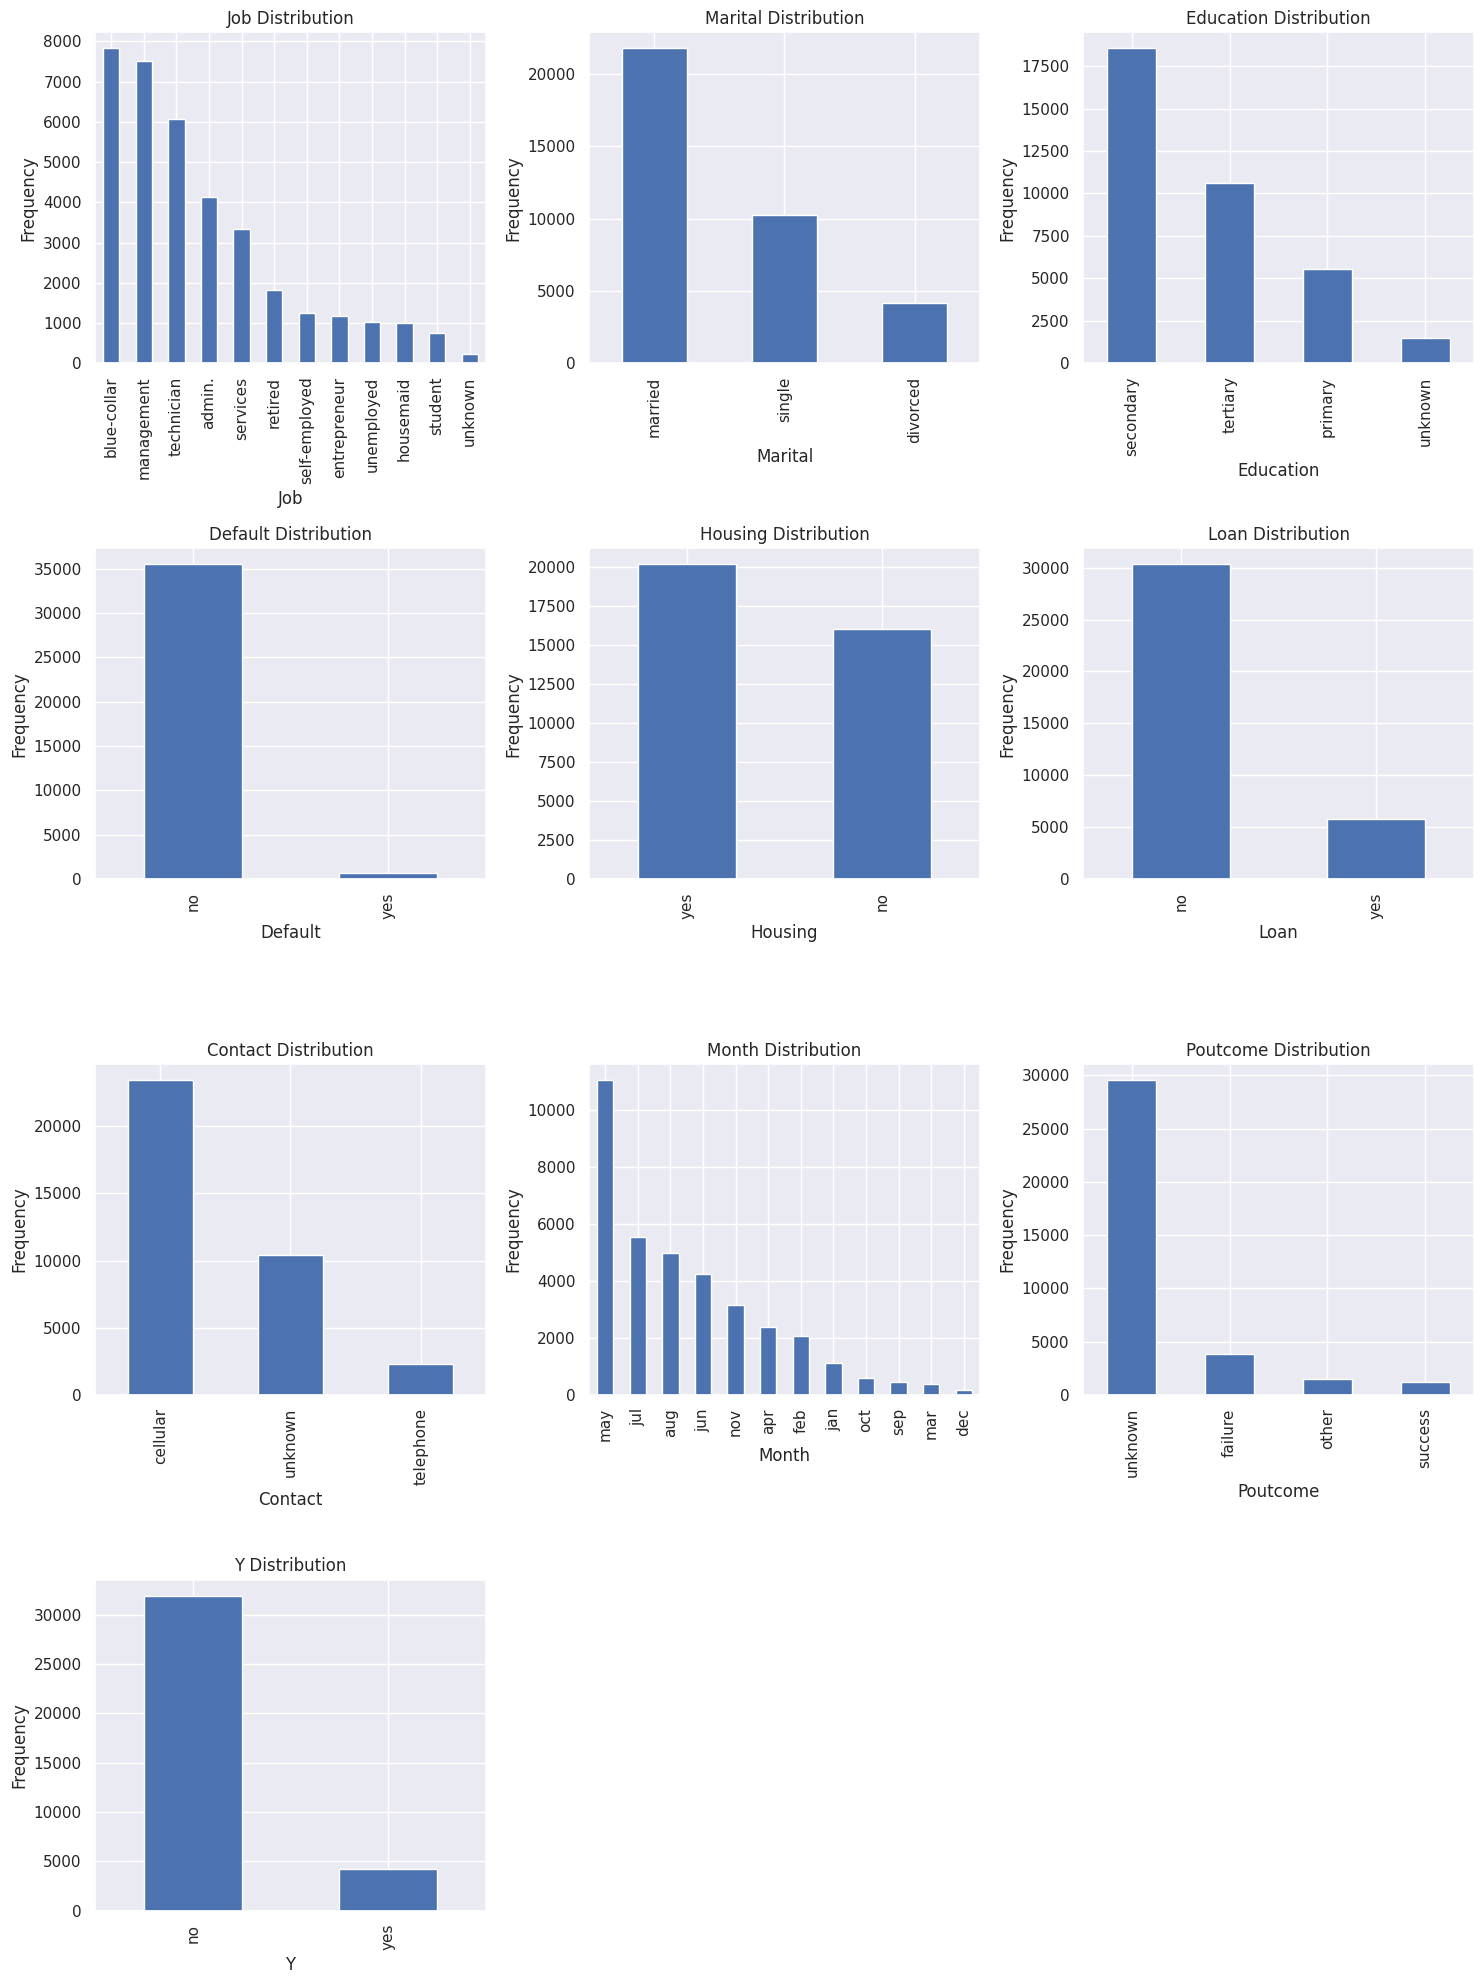

In [30]:
hist_categorical_columns(train_df, categorical_cols)

Después de aplicar SMOTENC:

In [31]:
y_smote_df = pd.DataFrame(y_smote).reset_index(drop=True)
smote_df = pd.concat([X_smote.reset_index(drop=True), y_smote_df], axis=1)

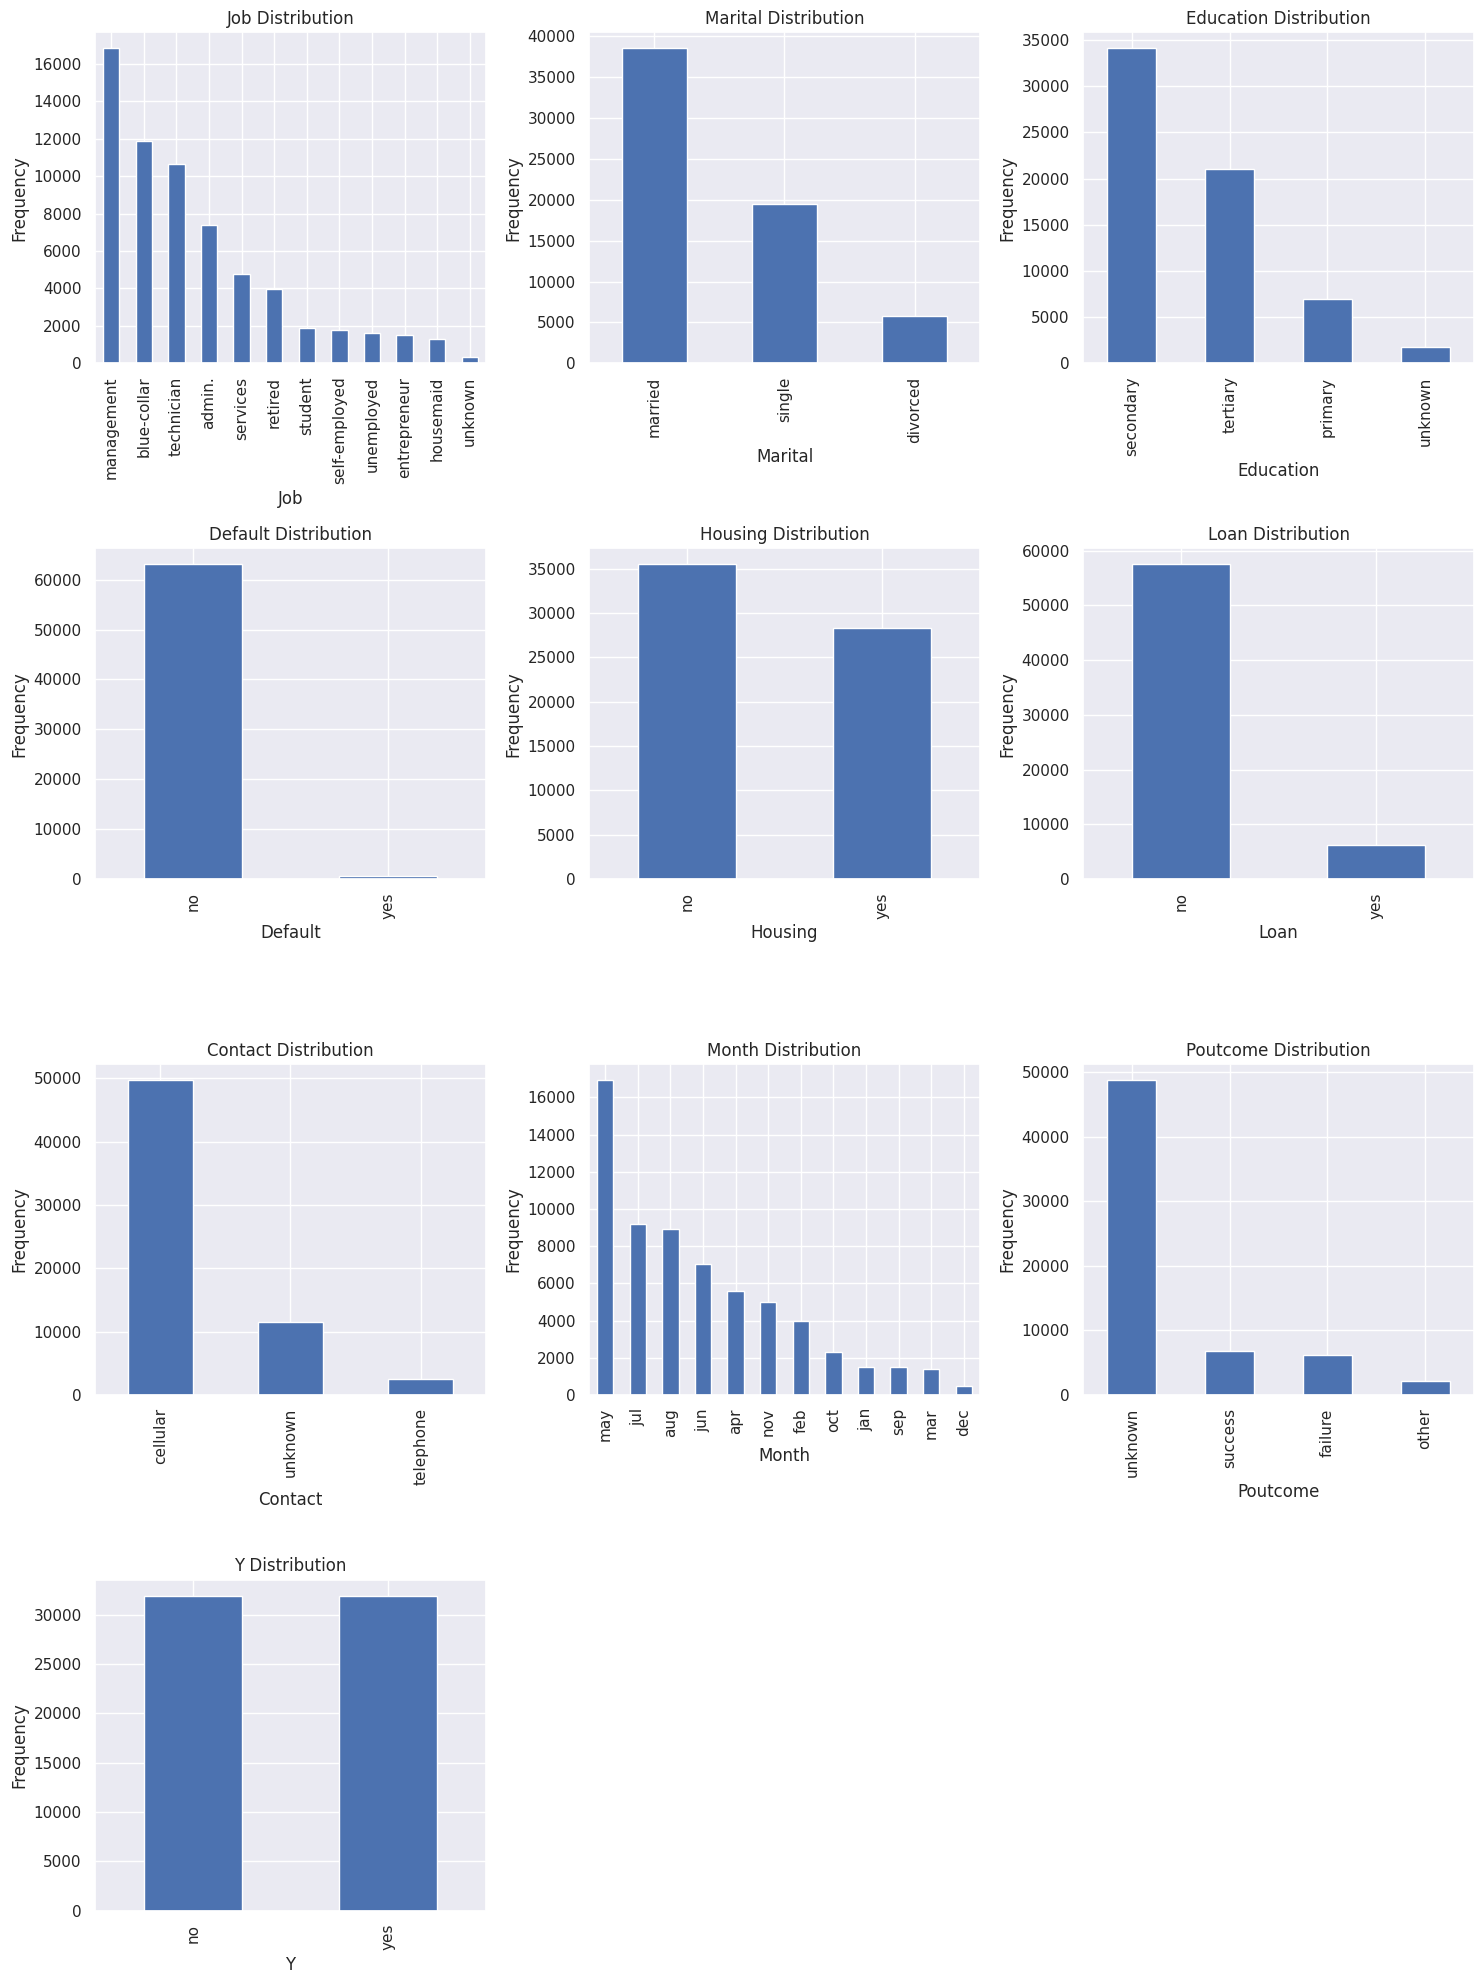

In [32]:
hist_categorical_columns(smote_df, categorical_cols)

**Como se puede ver ahora ambas target clases ('yes' y 'no') tienen frecuencias similares.** Si hubieran más target clases subrepresentadas también se hubieran igualado, SMOTENC toma todas las que no son mayoría.

# XGBoost
El primer modelo a implementar será XGBoost debido a su alta eficiencia, uso de regularización para evitar overfitting (L1 y L2), computación paralela, y generalmente es mucho más rápida al ser un modelo optimizado, diseñada para ser flexible y portátil.

La librería se ejecuta en los principales entornos distribuidos (Hadoop, SGE, MPI) y puede resolver problemas más allá de miles de millones de ejemplos.

Además, XGBoost es uno de los mejores modelos para clasificación de data y al estar basado en árboles de decisión permite la interpretación de sus resultados, lo cual es crucial para guiar las decisiones en la vida real.

In [33]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# Recordemos que 'smote_df' tiene todo el dataset de ENTRENAMIENTO
smote_df.head(1)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,36,technician,divorced,secondary,no,861,no,no,telephone,29,aug,140,2,-1,0,unknown,no


In [34]:
# Convert categorical variables to numeric
def encode_categorical_variables(data1):
  data = data1.copy()
  label_encoders = {}
  for column in categorical_cols:
      label_encoders[column] = LabelEncoder()  # Estamos usando el LabelEncoder() de scikit learn
      data[column] = label_encoders[column].fit_transform(data[column])

  # Split the data into features and target
  X = data.drop('y', axis=1)
  y = data['y']
  return X, y, label_encoders

# Recordemos que 'smote_df' es la data de entrenamiento con oversampling.
X_train_encoded, y_train_encoded, label_encoders = encode_categorical_variables(smote_df)

X_test_encoded, y_test_encoded, label_encoders1 = encode_categorical_variables(test_df)

In [35]:
X_train_encoded.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,36,9,0,1,0,861,0,0,1,29,1,140,2,-1,0,3
1,24,8,2,1,0,4126,0,0,0,5,0,907,4,185,7,0
2,44,9,2,1,0,244,1,0,0,12,1,1735,4,-1,0,3


In [36]:
y_train_encoded.value_counts()

y
0    31937
1    31937
Name: count, dtype: int64

In [ ]:
label_encoders

{'job': LabelEncoder(),
 'marital': LabelEncoder(),
 'education': LabelEncoder(),
 'default': LabelEncoder(),
 'housing': LabelEncoder(),
 'loan': LabelEncoder(),
 'contact': LabelEncoder(),
 'month': LabelEncoder(),
 'poutcome': LabelEncoder(),
 'y': LabelEncoder()}

In [37]:
import time

In [38]:
# Start the timer
training_start_time = time.time()

# Create and train the XGBoost model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train_encoded, y_train_encoded)

# End the timer
training_end_time = time.time()

# Start the timer
predicting_start_time = time.time()

# Make predictions and evaluate the model
y_pred_encoded = xgb_model.predict(X_test_encoded)

# End the timer
predicting_end_time = time.time()

accuracy = accuracy_score(y_test_encoded, y_pred_encoded)
precision = precision_score(y_test_encoded, y_pred_encoded)
recall = recall_score(y_test_encoded, y_pred_encoded)
f1 = f1_score(y_test_encoded, y_pred_encoded)

In [39]:
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

Accuracy: 0.885
Precision: 0.505
Recall: 0.711
F1 Score: 0.590


In [40]:
# Calculate the times
training_time = training_end_time - training_start_time
predicting_time = predicting_end_time - predicting_start_time

print(f"Training Time: {training_time} seconds")
print(f"Predicting Time: {predicting_time} seconds")

Training Time: 0.7746796607971191 seconds
Predicting Time: 0.030043363571166992 seconds


Yo considero que aquí **la métrica de importancia es Recall = TP/(TP + FN), de esta forma nos enfocamos en detectar todas las verdaderos positivos, es decir, cuando la persona si va adquirir un depósito, para no perder oportunidad de venta y enfocarnos en estas personas.** Vemos que el Recall es de 70.8% lo cual es relativamente aceptable.

Precision es más permisivo y no toma en cuenta FN, pero si FP, lo cual significa que se predice que hay personas que van a tener un depósito cuando probablemente no lo van a tener. De todas formas hay chance de que se les pueda convencer ya que el algoritmo cree que sus características son similares a las personas que sí realizan un depósito de plazo fijo.

In [ ]:
y_pred = label_encoders['y'].inverse_transform(y_pred_encoded)
y_pred

array(['no', 'no', 'no', ..., 'no', 'no', 'no'], dtype=object)

In [ ]:
y_test

1392     no
7518     no
12007    no
5536     no
29816    no
         ..
12636    no
13364    no
16102    no
42097    no
31033    no
Name: y, Length: 9043, dtype: object

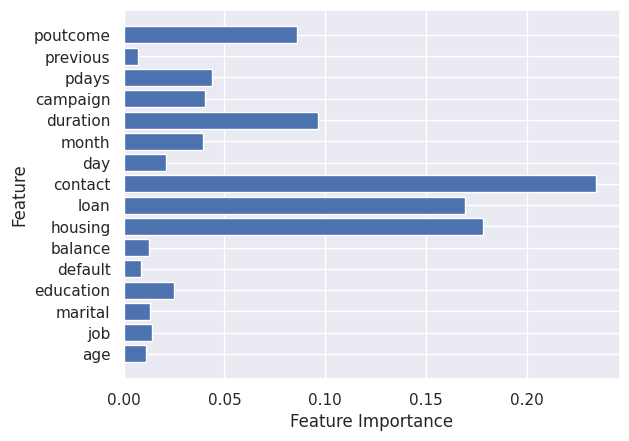

In [41]:
feature_importances = xgb_model.feature_importances_

# Plot feature importance
plt.barh(range(len(feature_importances)), feature_importances)
plt.yticks(range(len(feature_importances)), X_train_encoded.columns)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

In [42]:
feature_importances

array([0.01107327, 0.01404362, 0.01288157, 0.02472639, 0.00877598,
       0.01234341, 0.17809147, 0.16940834, 0.2344667 , 0.02102968,
       0.03929188, 0.09654851, 0.04048389, 0.04356017, 0.0071643 ,
       0.08611076], dtype=float32)

In [44]:
feature_importances_df = pd.DataFrame({'feature': X_train_encoded.columns, 'importance': feature_importances})
feature_importances_df.head(1)

,feature,importance
0,age,0.011073


In [47]:
# Create the horizontal bar chart using Plotly
fig = px.bar(feature_importances_df,
             x='importance',
             y='feature',
             orientation='h',
             title='Feature Importances',
             opacity=0.7)

# Show the plot
fig.show()

In [ ]:
from pyspark.sql.functions import lit, count, floor

# Filter out the rows where the target variable 'y' is 'yes'
positive_df = bank_df.filter(col('y') == 'yes')

# Count the occurrences of each value in the important columns when 'y' is 'yes'
contact_counts = positive_df.groupBy('contact').agg(count('*').alias('count')).orderBy('count', ascending=False)
loan_counts = positive_df.groupBy('loan').agg(count('*').alias('count')).orderBy('count', ascending=False)
housing_counts = positive_df.groupBy('housing').agg(count('*').alias('count')).orderBy('count', ascending=False)
poutcome_counts = positive_df.groupBy('poutcome').agg(count('*').alias('count')).orderBy('count', ascending=False)

# Show the results
print("Contact value counts leading to 'yes' in 'y':")
contact_counts.show()

print("Loan value counts leading to 'yes' in 'y':")
loan_counts.show()

print("Housing value counts leading to 'yes' in 'y':")
housing_counts.show()

print("Poutcome value counts leading to 'yes' in 'y':")
poutcome_counts.show()

Contact value counts leading to 'yes' in 'y':
+---------+-----+
|  contact|count|
+---------+-----+
| cellular| 4369|
|  unknown|  530|
|telephone|  390|
+---------+-----+

Loan value counts leading to 'yes' in 'y':
+----+-----+
|loan|count|
+----+-----+
|  no| 4805|
| yes|  484|
+----+-----+

Housing value counts leading to 'yes' in 'y':
+-------+-----+
|housing|count|
+-------+-----+
|     no| 3354|
|    yes| 1935|
+-------+-----+

Poutcome value counts leading to 'yes' in 'y':
+--------+-----+
|poutcome|count|
+--------+-----+
| unknown| 3386|
| success|  978|
| failure|  618|
|   other|  307|
+--------+-----+



In [ ]:
# Filter the DataFrame where the target variable 'y' is 'yes'
positive_df = bank_df_pandas[bank_df_pandas['y'] == 'yes']

# Plot the distribution of 'duration' values for positive outcomes using Plotly
fig = px.histogram(
    positive_df,
    x='duration',
    nbins=50,
    title='Distribution of Duration Leading to "Yes" in Target Variable',
    labels={'duration': 'Duration (seconds)', 'count': 'Count of "yes"'},
    opacity=0.7
)

# Update layout for better appearance
fig.update_layout(
    xaxis_title='Duration (seconds)',
    yaxis_title='Count of "yes"',
    bargap=0.1,
    bargroupgap=0.1
)

# Show the plot
fig.show()

#Insight de importancia de features:
Los features más importantes del data set que ayudan a determinar si la persona tendrá o no un depósito de plazo fijo son:
  * contact:  tipo de comunicación del último contacto. (≈24%). El valor que más se relaciona con un 'si' tiene depósito es contact='celular'.
  * loan: si tiene un crédito (≈15%). El valor que más se relaciona con un 'si' tiene depósito es loan='no'.
  * housing: si tiene una hipoteca (≈17%). El valor que más se relaciona con un 'si' tiene depósito es housing='no'.
  * duration: duración del último contacto, en segundos. Los valores que se relacionan más con un 'si' tienen depósito es entre 100 y 300 segundos (5min).
  * poutcome: resultado de la última campaña de marketing.

Se puede ver además que las demás variables tienen un nivel de importancia menor a 5%, con lo cual se podrían eliminar o juntar. Esto queda para futura experimentación.


# XGBoost con Pyspark
Se empleará el API que tiene XGBoost para usar pyspark.

* 'smote_df' contiene la data de entrenamiento con oversamplig sin codificar y target variable.
* 'test_df' contiene la data de testing sin codificar y target variable.

In [48]:
from xgboost.spark import SparkXGBClassifier

In [ ]:
smote_df.head(1)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,36,technician,divorced,secondary,no,861,no,no,telephone,29,aug,140,2,-1,0,unknown,no


In [ ]:
test_df.head(1)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,40,blue-collar,married,primary,no,640,yes,yes,unknown,8,may,347,2,-1,0,unknown,no


In [49]:
spark_df_train = spark.createDataFrame(smote_df)
spark_df_test = spark.createDataFrame(test_df)

In [ ]:
spark_df_train.show(2)

+---+----------+--------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+---+
|age|       job| marital|education|default|balance|housing|loan|  contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+----------+--------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+---+
| 36|technician|divorced|secondary|     no|    861|     no|  no|telephone| 29|  aug|     140|       2|   -1|       0| unknown| no|
| 24|   student|  single|secondary|     no|   4126|     no|  no| cellular|  5|  apr|     907|       4|  185|       7| failure|yes|
+---+----------+--------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+---+
only showing top 2 rows



In [ ]:
spark_df_train.schema

StructType([StructField('age', LongType(), True), StructField('job', StringType(), True), StructField('marital', StringType(), True), StructField('education', StringType(), True), StructField('default', StringType(), True), StructField('balance', LongType(), True), StructField('housing', StringType(), True), StructField('loan', StringType(), True), StructField('contact', StringType(), True), StructField('day', LongType(), True), StructField('month', StringType(), True), StructField('duration', LongType(), True), StructField('campaign', LongType(), True), StructField('pdays', LongType(), True), StructField('previous', LongType(), True), StructField('poutcome', StringType(), True), StructField('y', StringType(), True)])

In [50]:
# Convert categorical variables to numeric
def encode_categorical_variables_pyspark(data):
  for column in data.columns:
      if isinstance(data.schema[column].dataType, StringType):
          indexer = StringIndexer(inputCol=column, outputCol=column + "_indexed")
          data = indexer.fit(data).transform(data).drop(column).withColumnRenamed(column + "_indexed", column)
  return data

In [51]:
spark_df_train_encoded = encode_categorical_variables_pyspark(spark_df_train)
spark_df_test_encoded = encode_categorical_variables_pyspark(spark_df_test)

In [52]:
spark_df_train_encoded.show(2)

+---+-------+---+--------+--------+-----+--------+---+-------+---------+-------+-------+----+-------+-----+--------+---+
|age|balance|day|duration|campaign|pdays|previous|job|marital|education|default|housing|loan|contact|month|poutcome|  y|
+---+-------+---+--------+--------+-----+--------+---+-------+---------+-------+-------+----+-------+-----+--------+---+
| 36|    861| 29|     140|       2|   -1|       0|2.0|    2.0|      0.0|    0.0|    0.0| 0.0|    2.0|  2.0|     0.0|0.0|
| 24|   4126|  5|     907|       4|  185|       7|6.0|    1.0|      0.0|    0.0|    0.0| 0.0|    0.0|  4.0|     2.0|1.0|
+---+-------+---+--------+--------+-----+--------+---+-------+---------+-------+-------+----+-------+-----+--------+---+
only showing top 2 rows



In [53]:
# Assemble the features into a single vector
def AssembleFeatures(data):
  assembler = VectorAssembler(inputCols=[col for col in data.columns if col != 'y'], outputCol='features')
  data = assembler.transform(data).select('features', 'y')
  return data

In [54]:
spark_df_train_assembled = AssembleFeatures(spark_df_train_encoded)
spark_df_test_assembled = AssembleFeatures(spark_df_test_encoded)

In [55]:
spark_df_train_assembled.show(2)

+--------------------+---+
|            features|  y|
+--------------------+---+
|[36.0,861.0,29.0,...|0.0|
|[24.0,4126.0,5.0,...|1.0|
+--------------------+---+
only showing top 2 rows



In [56]:
# Start the timer
training_start_time = time.time()

# Train the SparkXGBClassifier
xgb_classifier = SparkXGBClassifier(label_col='y', features_col='features')
xgb_model = xgb_classifier.fit(spark_df_train_assembled)

# End the timer
training_end_time = time.time()

# Start the timer
predicting_start_time = time.time()

# Make predictions
predictions = xgb_model.transform(spark_df_test_assembled)

# End the timer
predicting_end_time = time.time()

INFO:XGBoost-PySpark:Running xgboost-2.1.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!


In [57]:
# Evaluate using MulticlassClassificationEvaluator for accuracy
evaluator = BinaryClassificationEvaluator(labelCol='y')
accuracy = evaluator.evaluate(predictions)

# Evaluate using MulticlassClassificationEvaluator for F1 score
evaluator = MulticlassClassificationEvaluator(labelCol='y', metricName='f1')
f1_score = evaluator.evaluate(predictions)

In [58]:
# Calculate precision and recall manually
true_positives = predictions.filter((col('y') == 1) & (col('prediction') == 1)).count()
false_positives = predictions.filter((col('y') == 0) & (col('prediction') == 1)).count()
false_negatives = predictions.filter((col('y') == 1) & (col('prediction') == 0)).count()

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1_score:.3f}")

Accuracy: 0.842
Precision: 0.322
Recall: 0.660
F1 Score: 0.825


In [59]:
# Calculate the training time
training_time = training_end_time - training_start_time
predicting_time = predicting_end_time - predicting_start_time

print(f"Training Time: {training_time} seconds")
print(f"Predicting Time: {predicting_time} seconds")

Training Time: 18.58016014099121 seconds
Predicting Time: 0.4779388904571533 seconds


Se obtuvieron casi los mismos resultados que con XGBoost sin pyspark.

# Gradient-Boosted Tree Classifier con PySpark

* 'smote_df' contiene la data de entrenamiento con oversamplig sin codificar y target variable.
* 'test_df' contiene la data de testing sin codificar y target variable.

In [60]:
# Start the timer
training_start_time = time.time()

# Create and train the Gradient-boosted tree classifier
gbt = GBTClassifier(labelCol='y', featuresCol='features', maxIter=10)
gbt_model = gbt.fit(spark_df_train_assembled)

# End the timer
training_end_time = time.time()

# Start the timer
predicting_start_time = time.time()

# Make predictions and evaluate the model
predictions = gbt_model.transform(spark_df_test_assembled)

# End the timer
predicting_end_time = time.time()


In [ ]:
# Evaluate using MulticlassClassificationEvaluator for F1 score
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol='y', metricName='f1')
f1_score = multiclass_evaluator.evaluate(predictions)

In [ ]:
predictions.show(2)

+--------------------+---+--------------------+--------------------+----------+
|            features|  y|       rawPrediction|         probability|prediction|
+--------------------+---+--------------------+--------------------+----------+
|[40.0,640.0,8.0,3...|0.0|[1.25177207934234...|[0.92438990548633...|       0.0|
|(16,[0,1,2,3,4,5,...|0.0|[0.76667735689711...|[0.82249661876973...|       0.0|
+--------------------+---+--------------------+--------------------+----------+
only showing top 2 rows



In [ ]:
# Calculate precision and recall manually
true_positives = predictions.filter((col('y') == 1) & (col('prediction') == 1)).count()
false_positives = predictions.filter((col('y') == 0) & (col('prediction') == 1)).count()
false_negatives = predictions.filter((col('y') == 1) & (col('prediction') == 0)).count()

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1_score:.3f}")

Accuracy: 0.797
Precision: 0.261
Recall: 0.685
F1 Score: 0.780


In [61]:
# Calculate the training time
training_time = training_end_time - training_start_time
predicting_time = predicting_end_time - predicting_start_time

print(f"Training Time: {training_time} seconds")
print(f"Predicting Time: {predicting_time} seconds")

Training Time: 18.236754417419434 seconds
Predicting Time: 0.15083694458007812 seconds


# Gradient Boosted Trees from YDT (TensorFlow)
Yggdrasil Decision Forest es la nueva librería de TensorFlow para entrenar, evaluar, interpretar y servir modelos de Random Forest, Gradient Boosted Decision Trees, y modelos CART decision forest.

Incluye los últimas investigaciones de decision forest. Es altamente personalizable e intregrado con las estructuras Deep Learning de TF.

In [63]:
!pip install ydf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 28.4 MB/s eta 0:00:00


In [64]:
import ydf

In [65]:
train_encoded_ds = pd.concat([X_train_encoded, y_train_encoded], axis=1)
test_encoded_ds = pd.concat([X_test_encoded, y_test_encoded], axis=1)

In [66]:
train_encoded_ds.head(1)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,36,9,0,1,0,861,0,0,1,29,1,140,2,-1,0,3,0


In [67]:
training_start_time = time.time()

# Train a Gradient Boosted Trees model
ydf_model = ydf.GradientBoostedTreesLearner(label="y").train(train_encoded_ds)

training_end_time = time.time()

Train model on 63874 examples
Model trained in 0:01:02.186774


In [68]:
# Look at a model (input features, training logs, structure, etc.)
ydf_model.describe()

In [74]:
predicting_start_time = time.time()

# Generate predictions
y_pred_encoded = ydf_model.predict(test_encoded_ds)

predicting_end_time = time.time()

In [75]:
y_pred_encoded

array([0.00406534, 0.00187653, 0.00336502, ..., 0.13472804, 0.00852087,
       0.26353285], dtype=float32)

In [80]:
# If y_pred contains continuous values, convert them to binary predictions
# for binary classification, you might use a threshold like 0.5
y_pred_binary = (y_pred_encoded > 0.5).astype(int)

In [83]:
accuracy = accuracy_score(y_test_encoded, y_pred_binary)
precision = precision_score(y_test_encoded, y_pred_binary)
recall = recall_score(y_test_encoded, y_pred_binary)

In [84]:
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

Accuracy: 0.881
Precision: 0.493
Recall: 0.739


In [69]:
# Evaluate a model (e.g. roc, accuracy, confusion matrix, confidence intervals)
ydf_model.evaluate(test_encoded_ds)

Label \ Pred,0,1
0,7181,276
1,804,782


In [71]:
# Analyse a model (e.g. partial dependence plot, variable importance)
ydf_model.analyze(test_encoded_ds)

# Benchmark the inference speed of a model
ydf_model.benchmark(test_encoded_ds)

Inference time per example and per cpu core: 4.353 us (microseconds)
Estimated over 129 runs over 5.078 seconds.
* Measured with the C++ serving API. Check model.to_cpp() for details.

# Resultados y comparación de modelos

A continuación, un resumen de las métricas:
* GBT: Recall = 68.5% | Tiempo entrenamiento: 18.24s | Tiempo predicción: 0.15s
* XGBoost: Recall = 70.8% | Tiempo entrenamiento: 0.77s | Tiempo predicción: 0.03s
* YDF: Recall = 73.9% | Tiempo entrenamiento: 5s | Tiempo predicción: 2s

**Podemos ver que el modelo XGBoost es mucho más eficiente en tiempo e incluso logra un mejor resultado de Recall que el modelo de GBT de PySpark.**

Por otro lado el modelo YDF es el que tiene mejor rendimiento, pero el tiempo de entrenamiento con la misma data de los demás modelos es mucho mayor que el XGBoost. Con un incremento de tiempo de +600% solo se mejoró el recall un 3.1%.

Habría que validar estos tiempo realizando iteraciones de entrenamiento en múltiplos subsets de la data y obtener el promedio de tiempos y métricas.

# Mejoras por Implementar
**EDA**
* Estudiar un poco más las variables con estadística descriptiva (cuartiles, evaluar distribución normal, otros)
* Realizar análisis bivariable de la variable 'contact' que fue la que faltó analizar más a detalle y es de gran relevancia.
* Realizar más análisis multi variables para entender interdependencia y ver cómo explotar estos aspectos en la vida real. Entender necesidades y crear productos para los diferentes grupos que sean rentables.


**Feature Engineering**
* Juntar, eliminar y otros procesos a las variables que no tienen mucha relevancia en el modelo. Incluso se puede mejorar las variables más importantes al juntarlas con otras variables. Lo importante es que tenga sentido racional en la vida real el resultado de juntar las variables y poder enfocarse en ese aspecto durante la campaña de marketing.

**Training & Experimentation**
* Experimentar con diferentes hiperparámetros de los modelos empleados, limitar el número de estimadores, el máximo de profundidad, número de trabajadores, entre otros.
* Implementar otros modelos no relacionados con Decision Trees para luego aplicar algún Ensamble Method (voting, bagging, pasting), usar los predictores débiles para obtener un resultado mejor.
* Analizar los resultados de los modelos, pues los modelos basados en Decision Trees facilitan el análisis de importancia de features.

**MLOps**
* Implementar un adecuado pipeline guardando los estados de la data, modelo y resultados. Entiendo Pyspark pipeline es similar al pipeline de TensorFlow Extended. Yo estoy familiarizado con este último porque llevé cursos de él y estuve aprendiendo cómo usarlo.

# Feature Selection
Dentro de los principales métodos para seleccionar variables se encuentran:
* **Filter Methods:** Se aplican antes de entrenar el modelo, por ende, independientes de él.
  * Coeficiente de Correlación y Chi-Square Test. Estos métodos ya fueron empleados en el análisis con dos variables.
* **Wrapper Methods:** Evalúan el perfomance del modelo usando un subconjunto de features e iteran para seleccionar aquellos que optimizan el resultado.
  * Recursive Feature Elimination (RFE):
Se procederá a implementar